In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

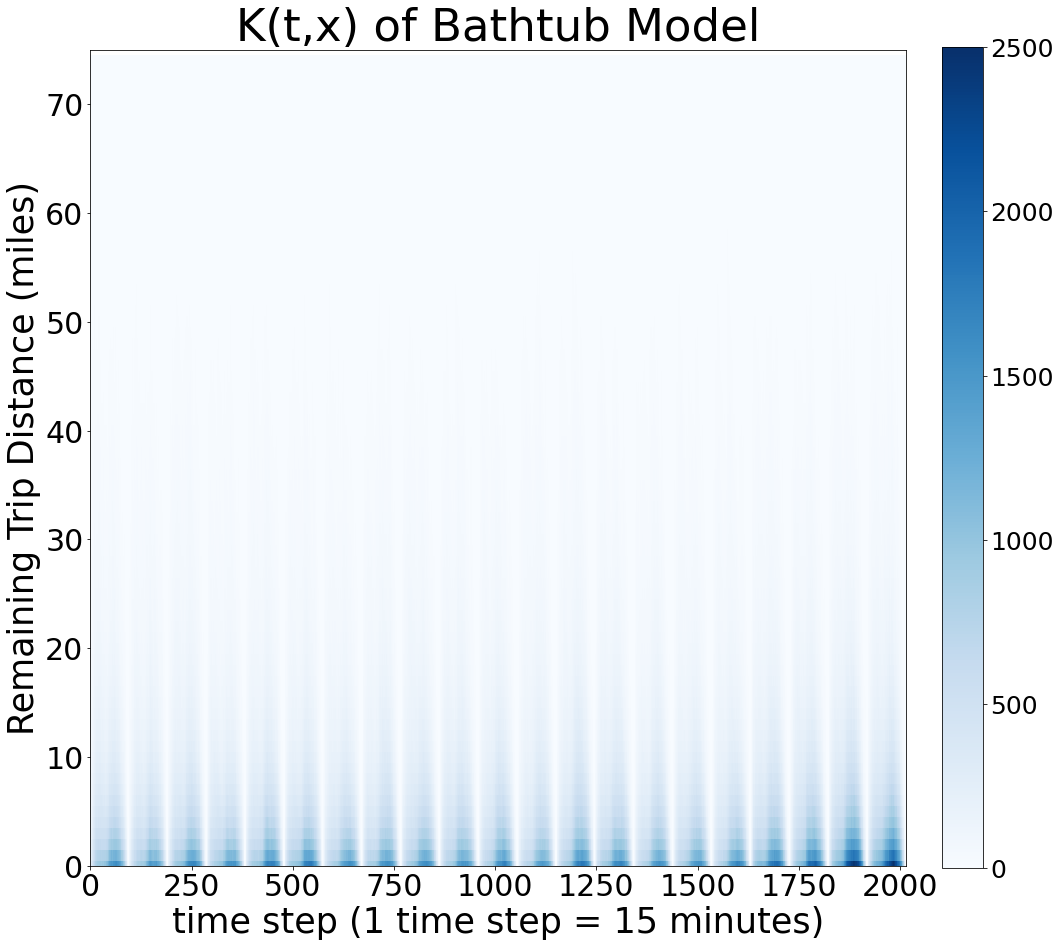

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  25200
N_u =  5040
N_f =  10080


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(5040, 2)

In [12]:
X_u_test.shape

(20160, 2)

In [13]:
X_u_train

array([[0.36486486, 0.12704715],
       [0.72972973, 0.41588089],
       [0.44594595, 0.97270471],
       ...,
       [0.72972973, 0.39801489],
       [0.64864865, 0.14094293],
       [0.97297297, 0.81488834]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0086915052333867635 0.0086915052333867635 0.8320642414824607
0.0078344171210630829 0.0078344171210630829 0.7907661810716988
0.0072938340317092974 0.0072938340317092974 0.7637788794856025
0.007254834350792716 0.007254834350792716 0.7620196503680888
0.0071906941982590785 0.0071906941982590785 0.7591688248568611
0.0071424137469299582 0.0071424137469299582 0.7568927548642101
0.00693062425374977 0.00693062425374977 0.7465213223393934
0.0066945781280715339 0.0066945781280715339 0.734807215086198
0.0065047133470556026 0.0065047133470556026 0.7253135894121568
0.0062185976957768686 0.0062185976957768686 0.7097634989385629
0.0058651507945122472 0.0058651507945122472 0.6885654340601609
0.0058254311650879805 0.0058254311650879805 0.6863141969272323
0.005805404366306088 0.005805404366306088 0.685191806489596
0.0057824309016222906 0.0057824309016222906 0.6839821733592827
0.0057396721612341453 0.0057396721612341453 0.6818780539413434
0.0056513086234733639 0.0056513086234733639 0.6771030513069143
0.

0.0022117692012475873 0.0022117692012475873 0.4373497552101843
0.0022117374317693669 0.0022117374317693669 0.4373788189143195
0.0022116524156735335 0.0022116524156735335 0.43741720410067936
0.0022115907877873786 0.0022115907877873786 0.43743291784016636
0.002211538455818356 0.002211538455818356 0.4374777805292966
0.0022114925704227019 0.0022114925704227019 0.43745498787275217
0.0022114387426356926 0.0022114387426356926 0.4374382009939423
0.0022112834672755729 0.0022112834672755729 0.4373542574824525
0.0022110839996364417 0.0022110839996364417 0.4372641123992788
0.0022108820268162289 0.0022108820268162289 0.4372321143772776
0.0022105613248068643 0.0022105613248068643 0.4373027728428567
0.0022099781599925509 0.0022099781599925509 0.43709381827836485
0.0022089168007952045 0.0022089168007952045 0.43708248108576286
0.0022063078307283418 0.0022063078307283418 0.43711123611425257
0.0022058168948885229 0.0022058168948885229 0.43705109254641905
0.0022042776089701574 0.0022042776089701574 0.4370

0.0021859268927987858 0.0021859268927987858 0.4345247208161656
0.0021858580959383711 0.0021858580959383711 0.43449913464306544
0.0021857162202036404 0.0021857162202036404 0.43447167558528066
0.0021856509355507978 0.0021856509355507978 0.4344915768700359
0.0021855094514036141 0.0021855094514036141 0.4344477081078054
0.0021854071392603935 0.0021854071392603935 0.43441617892369766
0.0021852608493544267 0.0021852608493544267 0.43444626682084275
0.0021851924186563755 0.0021851924186563755 0.43459884720756303
0.0021850176110132175 0.0021850176110132175 0.43447498006736235
0.0021849319280744595 0.0021849319280744595 0.43442608236950686
0.0021848675747639565 0.0021848675747639565 0.4343649575225697
0.0021848285193512684 0.0021848285193512684 0.4343715293091656
0.0021847960241242735 0.0021847960241242735 0.4343678061533097
0.0021847745759983189 0.0021847745759983189 0.43440621578009725
0.0021847060294073253 0.0021847060294073253 0.43443127943192505
0.0021845504353349846 0.0021845504353349846 0.

0.0021556474690656844 0.0021556474690656844 0.434764087636168
0.0021554135540391142 0.0021554135540391142 0.43467824314130815
0.0021552308238686857 0.0021552308238686857 0.4346416995155732
0.0021551636972400928 0.0021551636972400928 0.4348420263905885
0.0021551139227126525 0.0021551139227126525 0.4348571533633376
0.0021550284549485413 0.0021550284549485413 0.43484665238904063
0.0021549708320706758 0.0021549708320706758 0.4348343653275417
0.0021548850433441335 0.0021548850433441335 0.4348449481679145
0.0021547036172032464 0.0021547036172032464 0.4348237510958642
0.0021546236500561652 0.0021546236500561652 0.4349792189150429
0.0021544660675134526 0.0021544660675134526 0.43477408683535457
0.0021543987057660958 0.0021543987057660958 0.4346546004867934
0.0021543554310951931 0.0021543554310951931 0.43456551936992355
0.0021543140602434275 0.0021543140602434275 0.434551007676788
0.0021542802760415153 0.0021542802760415153 0.4345374193421208
0.0021541889579286691 0.0021541889579286691 0.4345624

0.0021438436456920991 0.0021438436456920991 0.4362309445312699
0.0021438172708429476 0.0021438172708429476 0.43618282570706046
0.0021437841167795913 0.0021437841167795913 0.43612913986480334
0.0021437372174868074 0.0021437372174868074 0.4360810698441693
0.0021437115294258235 0.0021437115294258235 0.4360605589369527
0.0021436525201042672 0.0021436525201042672 0.436090547937454
0.0021436038264087865 0.0021436038264087865 0.4361551215235222
0.0021435818290909663 0.0021435818290909663 0.43620274333862735
0.0021435300700061929 0.0021435300700061929 0.43623632501631665
0.0021434997608321496 0.0021434997608321496 0.43632534752557
0.002143445521500999 0.002143445521500999 0.4363162235057179
0.0021433597825495582 0.0021433597825495582 0.43632661697329606
0.002143241775159635 0.002143241775159635 0.43626846552432164
0.0021431747318160512 0.0021431747318160512 0.4362968824192013
0.0021430924587642446 0.0021430924587642446 0.4362037535374574
0.002142973757058781 0.002142973757058781 0.436317128412

0.0021348915809648733 0.0021348915809648733 0.43667487211733585
0.0021348351680197265 0.0021348351680197265 0.4366555995185336
0.0021347616273512705 0.0021347616273512705 0.4365676428408718
0.0021347184451994475 0.0021347184451994475 0.43659617741765405
0.0021346811582073143 0.0021346811582073143 0.43663450420956174
0.0021346281657307576 0.0021346281657307576 0.4366457179784428
0.00213455155009474 0.00213455155009474 0.4366696567499472
0.0021344846856021869 0.0021344846856021869 0.4368325623633134
0.0021343762912179893 0.0021343762912179893 0.4369694751462446
0.0021343191957492054 0.0021343191957492054 0.43691615041450027
0.0021342800813118133 0.0021342800813118133 0.4369700638840601
0.002134210677258525 0.002134210677258525 0.4370137304579962
0.0021341813945669366 0.0021341813945669366 0.43707477731683475
0.0021341051667018739 0.0021341051667018739 0.4371033460958737
0.0021340341664233594 0.0021340341664233594 0.4372125155128343
0.0021339142749398987 0.0021339142749398987 0.4369713871

0.0021239035566984906 0.0021239035566984906 0.43745623965126634
0.0021237844568611467 0.0021237844568611467 0.4373364601043201
0.002123658659699176 0.002123658659699176 0.43726488496352406
0.002123569114439906 0.002123569114439906 0.4373568433319394
0.0021233960861149165 0.0021233960861149165 0.43743590971890667
0.0021233567215546167 0.0021233567215546167 0.4374056605366415
0.0021232987966446045 0.0021232987966446045 0.437317766531353
0.0021232110760860232 0.0021232110760860232 0.43729018757431937
0.0021231826920689238 0.0021231826920689238 0.43729207099766104
0.0021231339256289746 0.0021231339256289746 0.43735266229300596
0.0021230367672154674 0.0021230367672154674 0.4372919102141214
0.0021229803073654664 0.0021229803073654664 0.4373208249613155
0.0021229076923028238 0.0021229076923028238 0.43713448484961676
0.002122844822351816 0.002122844822351816 0.43734907300817877
0.0021227982693920052 0.0021227982693920052 0.4372704058791465
0.0021227884250741773 0.0021227884250741773 0.43706222

0.0021194323705572122 0.0021194323705572122 0.43786803619499143
0.0021194249222556568 0.0021194249222556568 0.43785675205246455
0.0021194138719017419 0.0021194138719017419 0.4378493716931918
0.0021194010787078587 0.0021194010787078587 0.43788137423120427
0.0021193893551124288 0.0021193893551124288 0.4379873717850435
0.0021193831252084485 0.0021193831252084485 0.43798657201395785
0.0021193782186730813 0.0021193782186730813 0.4379900645239788
0.0021193764114964273 0.0021193764114964273 0.43799098939890463
0.0021193744283315593 0.0021193744283315593 0.4379758965790258
0.0021193728634602989 0.0021193728634602989 0.4379721050503376
0.00211937059108607 0.00211937059108607 0.43798099118566947
0.0021193686220155085 0.0021193686220155085 0.4379874375033215
0.0021193655888794268 0.0021193655888794268 0.4380032522343227
0.0021193582036089934 0.0021193582036089934 0.4380319456028445
0.0021193477310265905 0.0021193477310265905 0.43806826237949675
0.0021193366243531164 0.0021193366243531164 0.438114

0.0021127238402260198 0.0021127238402260198 0.44015458741706764
0.002112599522795541 0.002112599522795541 0.44029455274844764
0.0021124986717038852 0.0021124986717038852 0.4403215735148373
0.0021123590070449448 0.0021123590070449448 0.4404644847691967
0.0021122473567251666 0.0021122473567251666 0.44028341072901633
0.0021121930719875913 0.0021121930719875913 0.44026561262239666
0.0021121122752927809 0.0021121122752927809 0.4403166092337811
0.0021119954482196539 0.0021119954482196539 0.4402629054492283
0.0021118804649137624 0.0021118804649137624 0.44041917420001425
0.0021117904108876443 0.0021117904108876443 0.44038688169765927
0.0021117683155664362 0.0021117683155664362 0.44036116795542013
0.0021117595848633448 0.0021117595848633448 0.4403508851731334
0.0021117326570129487 0.0021117326570129487 0.4401183597637306
0.0021116843780122161 0.0021116843780122161 0.4401481931757523
0.0021115970910355652 0.0021115970910355652 0.44019343605461575
0.0021114665973348545 0.0021114665973348545 0.440

0.0020925011082338924 0.0020925011082338924 0.4377834697822502
0.0020923283551056581 0.0020923283551056581 0.4377683275983292
0.0020921377928721637 0.0020921377928721637 0.4377808670496102
0.0020917219883926793 0.0020917219883926793 0.43716665909222574
0.0020914510386249472 0.0020914510386249472 0.4372582544272314
0.0020911396755351782 0.0020911396755351782 0.43711721237077045
0.002090916656651814 0.002090916656651814 0.4374536239113181
0.0020907827809896946 0.0020907827809896946 0.43739461333761354
0.0020905310438188388 0.0020905310438188388 0.43715286076282023
0.00209018832278263 0.00209018832278263 0.4371244605909358
0.0020900453227702168 0.0020900453227702168 0.4366390168961673
0.0020897999432855272 0.0020897999432855272 0.43669703339012006
0.0020896021830069103 0.0020896021830069103 0.43672373861628694
0.0020893804038696275 0.0020893804038696275 0.43641921755806556
0.0020890982886034005 0.0020890982886034005 0.43589244890851375
0.0020887926170034135 0.0020887926170034135 0.4354502

0.00204985203214746 0.00204985203214746 0.42839727320208315
0.0020493792318692318 0.0020493792318692318 0.4284270751199488
0.0020491659722270427 0.0020491659722270427 0.42789410468754957
0.0020488426510548892 0.0020488426510548892 0.42803394139114886
0.0020484304782099733 0.0020484304782099733 0.42844287896922795
0.0020480133988699831 0.0020480133988699831 0.42853474037127065
0.0020476599666173368 0.0020476599666173368 0.4283124198732986
0.0020470843530976451 0.0020470843530976451 0.4282224340941589
0.0020465273394680533 0.0020465273394680533 0.4283396321688307
0.0020460040615181735 0.0020460040615181735 0.42853046887478086
0.0020457982124635538 0.0020457982124635538 0.42818108213148537
0.0020454999990545384 0.0020454999990545384 0.4280828133701167
0.0020449923339557609 0.0020449923339557609 0.4280998167610842
0.0020446811853683396 0.0020446811853683396 0.4280202502174167
0.002044574269365022 0.002044574269365022 0.42799245541103714
0.0020445110531796093 0.0020445110531796093 0.4278886

0.0020237109621430208 0.0020237109621430208 0.4385484080104542
0.0020235120460564138 0.0020235120460564138 0.4394451244974956
0.0020233335802719737 0.0020233335802719737 0.4385068973738357
0.0020231017276340778 0.0020231017276340778 0.43871878516235857
0.0020228297524949135 0.0020228297524949135 0.4400480523534615
0.0020225062792626715 0.0020225062792626715 0.4393187770071761
0.0020221121085935755 0.0020221121085935755 0.4396157516483664
0.0020219702687689725 0.0020219702687689725 0.43967499465841614
0.0020216242819964649 0.0020216242819964649 0.439397147340691
0.0020214667777614151 0.0020214667777614151 0.43984270802342834
0.0020209381088741075 0.0020209381088741075 0.4410250628922576
0.0020206959623639657 0.0020206959623639657 0.44139282371762334
0.002020276783351726 0.002020276783351726 0.4402310321249698
0.0020200002121130841 0.0020200002121130841 0.4404294809036657
0.0020195884515851743 0.0020195884515851743 0.4418509426852875
0.0020193390553071545 0.0020193390553071545 0.44270646

0.0019605186308272898 0.0019605186308272898 0.4459717959281632
0.00195971291311829 0.00195971291311829 0.4393297152591119
0.0019595512309578469 0.0019595512309578469 0.43838036272141556
0.0019594176022547844 0.0019594176022547844 0.4380793095961359
0.001959077604797555 0.001959077604797555 0.4375944819532661
0.0019588125102052412 0.0019588125102052412 0.4354982666627092
0.0019585663525514309 0.0019585663525514309 0.43556575988564616
0.0019580857609246753 0.0019580857609246753 0.43340287060564336
0.0019575273674021271 0.0019575273674021271 0.4299121859608744
0.0019570456062555606 0.0019570456062555606 0.43051010667037387
0.0019562169111990769 0.0019562169111990769 0.42984287767399065
0.00195598317460071 0.00195598317460071 0.42877575976887644
0.0019553052421059478 0.0019553052421059478 0.4305752148286444
0.0019545202863060036 0.0019545202863060036 0.4308485943354017
0.0019537054510474238 0.0019537054510474238 0.43074173229533863
0.0019531993008146597 0.0019531993008146597 0.430553999533

0.0019110152471036269 0.0019110152471036269 0.6348645660144461
0.0019109374625859298 0.0019109374625859298 0.6332222619125095
0.0019108958088435513 0.0019108958088435513 0.6326480060909538
0.0019108272496293657 0.0019108272496293657 0.6325999813171448
0.001910806703202785 0.001910806703202785 0.6340794988519834
0.0019107330891825823 0.0019107330891825823 0.6337925732425502
0.00191065881430882 0.00191065881430882 0.6339104875210698
0.0019105224098398146 0.0019105224098398146 0.6342089840851849
0.0019103756032912533 0.0019103756032912533 0.6352764713099923
0.0019101705361633319 0.0019101705361633319 0.6378809789112536
0.0019099272117984864 0.0019099272117984864 0.6371997682535924
0.0019098077503426065 0.0019098077503426065 0.6379107723299927
0.0019096483795152848 0.0019096483795152848 0.6388096222143855
0.0019095497999974196 0.0019095497999974196 0.6392196939043389
0.0019093728169853076 0.0019093728169853076 0.6393103573942396
0.0019092733625991427 0.0019092733625991427 0.640876720570023

0.0018610619954680992 0.0018610619954680992 0.5007116359197912
0.0018609407032034379 0.0018609407032034379 0.4998151796951476
0.0018608400798222082 0.0018608400798222082 0.49894172250685365
0.0018607707383551165 0.0018607707383551165 0.49903249714815195
0.0018606279608094278 0.0018606279608094278 0.499150916799136
0.0018604440434298005 0.0018604440434298005 0.499691613427875
0.0018602374608765334 0.0018602374608765334 0.4995250145679681
0.0018601612407631043 0.0018601612407631043 0.49905987836136473
0.001860032506471991 0.001860032506471991 0.4982514816359122
0.0018598694373689135 0.0018598694373689135 0.4973791665875809
0.0018597343933700926 0.0018597343933700926 0.4965513077116205
0.0018594929401700583 0.0018594929401700583 0.49479146007650604
0.0018591877289787313 0.0018591877289787313 0.4950180131887502
0.0018590063219312213 0.0018590063219312213 0.498059910800356
0.001858551994030309 0.001858551994030309 0.4968007738732385
0.0018583820273849333 0.0018583820273849333 0.495057922489

0.0018452842889264463 0.0018452842889264463 0.5050233397845213
0.0018452313658468 0.0018452313658468 0.5052476361190799
0.0018451200325436954 0.0018451200325436954 0.5073112723651609
0.0018450544294117996 0.0018450544294117996 0.5087188890501925
0.0018450227832371594 0.0018450227832371594 0.5104547540887427
0.0018449760401397888 0.0018449760401397888 0.5128303355995623
0.0018449412052026666 0.0018449412052026666 0.5139366992491423
0.0018449017155471115 0.0018449017155471115 0.51596334208902
0.0018448611655075839 0.0018448611655075839 0.5144222480230737
0.0018448270270485371 0.0018448270270485371 0.5153550696334441
0.0018448063170400603 0.0018448063170400603 0.5153698602455411
0.0018447950544711693 0.0018447950544711693 0.5150121185471337
0.0018447892634722368 0.0018447892634722368 0.5152109390714411
0.0018447832816269978 0.0018447832816269978 0.5148606390981827
0.0018447734379196188 0.0018447734379196188 0.5152487572927528
0.001844760462316411 0.001844760462316411 0.5155104076962009
0.

0.0018385889216894612 0.0018385889216894612 0.4784985591139418
0.0018384165663362596 0.0018384165663362596 0.4775121926331313
0.0018382631223590837 0.0018382631223590837 0.4774339109278585
0.0018381290198333658 0.0018381290198333658 0.4779892390190226
0.0018379218009807892 0.0018379218009807892 0.4776973315586611
0.0018377147719508939 0.0018377147719508939 0.47715829554045
0.0018375705323967074 0.0018375705323967074 0.4754701984687559
0.00183752836673954 0.00183752836673954 0.47523348894007206
0.0018374683198831151 0.0018374683198831151 0.4752790747885792
0.0018374538387631106 0.0018374538387631106 0.47511736519316616
0.0018374304419324907 0.0018374304419324907 0.47515234260442596
0.0018374170073001939 0.0018374170073001939 0.47501899013141813
0.001837406688723241 0.001837406688723241 0.4752150293118376
0.0018373978320553007 0.0018373978320553007 0.47754595288757645
0.0018373764490253579 0.0018373764490253579 0.47746262154023145
0.001837369376313912 0.001837369376313912 0.4779862095767

0.0018312421617669387 0.0018312421617669387 0.42088514214285255
0.0018312352320085392 0.0018312352320085392 0.42057368446426635
0.0018312287531352563 0.0018312287531352563 0.42025270956263744
0.0018312195476871049 0.0018312195476871049 0.42018515959991204
0.0018311929948277587 0.0018311929948277587 0.4201534084147686
0.001831128010356143 0.001831128010356143 0.420041168133613
0.0018310329655925179 0.0018310329655925179 0.42080572306742475
0.0018308936377865069 0.0018308936377865069 0.42145170870812965
0.0018307327393826485 0.0018307327393826485 0.42395715759988484
0.0018306428245815818 0.0018306428245815818 0.42442787637065194
0.0018304996315849338 0.0018304996315849338 0.4240846445379352
0.0018304508900149356 0.0018304508900149356 0.4237372635261676
0.0018304200769547099 0.0018304200769547099 0.42429607738991987
0.0018303841799957423 0.0018303841799957423 0.42504639221228274
0.0018303453770099338 0.0018303453770099338 0.42494758738460225
0.0018302826078902457 0.0018302826078902457 0.4

0.0018246873847445775 0.0018246873847445775 0.41420326101571764
0.0018246466209194641 0.0018246466209194641 0.4143547434631192
0.0018245993997126977 0.0018245993997126977 0.4144366089023765
0.0018245886317092932 0.0018245886317092932 0.4144742120173063
0.0018245560239544395 0.0018245560239544395 0.41448975370725644
0.0018245455189253672 0.0018245455189253672 0.4144847858102066
0.0018245339959177948 0.0018245339959177948 0.4144474023165469
0.0018245288609546248 0.0018245288609546248 0.414458087009654
0.001824521908854126 0.001824521908854126 0.4144127695503423
0.0018245153984016956 0.0018245153984016956 0.41439264537716014
0.0018245078969275929 0.0018245078969275929 0.4143997654790491
0.0018245008501665818 0.0018245008501665818 0.41438272193314035
0.0018244912843635263 0.0018244912843635263 0.414374144628999
0.0018244807237506114 0.0018244807237506114 0.4144247051967078
0.0018244627661471373 0.0018244627661471373 0.4144881076293135
0.0018244466648267017 0.0018244466648267017 0.414528090

0.0018220066346554928 0.0018220066346554928 0.41657990741891826
0.0018219564300984588 0.0018219564300984588 0.41661447279356945
0.0018219145772626288 0.0018219145772626288 0.4165876198599645
0.0018218749125107595 0.0018218749125107595 0.4166356960380227
0.0018218575887938018 0.0018218575887938018 0.41667681564014153
0.0018218274511487599 0.0018218274511487599 0.4165687803019404
0.0018218010777743569 0.0018218010777743569 0.4164422869936128
0.0018217895548359019 0.0018217895548359019 0.4163346574606158
0.0018217492097993267 0.0018217492097993267 0.4160738359798971
0.0018216958435203286 0.0018216958435203286 0.4157418179331591
0.0018216663702012178 0.0018216663702012178 0.4155807022342807
0.0018215994815339756 0.0018215994815339756 0.41537676723969075
0.0018214873057975441 0.0018214873057975441 0.4154646443185858
0.0018214554863971509 0.0018214554863971509 0.4152781964525559
0.0018214016578836851 0.0018214016578836851 0.4151985631001039
0.0018213462698679769 0.0018213462698679769 0.41527

0.0018173291377725459 0.0018173291377725459 0.41259725027290783
0.001817320667769818 0.001817320667769818 0.41266613053960993
0.0018172667154890576 0.0018172667154890576 0.4125910306672952
0.0018172468629148268 0.0018172468629148268 0.41262588513434184
0.0018171995443916887 0.0018171995443916887 0.41278892586161553
0.001817165410510898 0.001817165410510898 0.41290658678281644
0.0018171609741514778 0.0018171609741514778 0.41322901084472563
0.0018170913409970772 0.0018170913409970772 0.4129884100275994
0.0018170739729605145 0.0018170739729605145 0.4129879940620838
0.0018170315648763562 0.0018170315648763562 0.41276814106228354
0.0018170054742688237 0.0018170054742688237 0.4126281515464767
0.0018169486470905921 0.0018169486470905921 0.41256953299496607
0.0018168747146902313 0.0018168747146902313 0.4123988227443998
0.0018167800298511734 0.0018167800298511734 0.41204565912889696
0.0018167550381125305 0.0018167550381125305 0.412012771295132
0.001816718841115602 0.001816718841115602 0.4118975

0.0018145194878835358 0.0018145194878835358 0.4096407811911152
0.001814469230402603 0.001814469230402603 0.4094201392733249
0.0018143941716427113 0.0018143941716427113 0.4096514376666811
0.0018143320819199809 0.0018143320819199809 0.40947338132813843
0.0018142162953401232 0.0018142162953401232 0.40922152251180954
0.0018140578412154183 0.0018140578412154183 0.40879308787711854
0.001813991516924425 0.001813991516924425 0.40887218426699595
0.0018139516301031782 0.0018139516301031782 0.40887012703866044
0.0018138715717906735 0.0018138715717906735 0.4088366040707789
0.0018137646538808744 0.0018137646538808744 0.40895000747288685
0.0018136503234863555 0.0018136503234863555 0.40891377793579103
0.0018136046525144686 0.0018136046525144686 0.408847340096261
0.0018135169842732938 0.0018135169842732938 0.408742344806554
0.0018134542367742455 0.0018134542367742455 0.4086813182556558
0.0018134235162624132 0.0018134235162624132 0.4087787398090819
0.0018133473805118886 0.0018133473805118886 0.40861140

0.0018111376600867121 0.0018111376600867121 0.40482626075386685
0.0018111237896229163 0.0018111237896229163 0.4049643752143254
0.0018111168829481083 0.0018111168829481083 0.4049885899170891
0.0018111083331227621 0.0018111083331227621 0.4049781980024548
0.0018110986023598091 0.0018110986023598091 0.404954586575297
0.0018110810745878849 0.0018110810745878849 0.4050276088886085
0.0018110563466974972 0.0018110563466974972 0.40511870032246683
0.0018110398655088046 0.0018110398655088046 0.40525310387138397
0.0018110216464978766 0.0018110216464978766 0.40533497419845954
0.0018110088383081278 0.0018110088383081278 0.4053470299005679
0.0018109915705372447 0.0018109915705372447 0.40543944200040527
0.0018109735344034477 0.0018109735344034477 0.4053653736895108
0.0018109346130057223 0.0018109346130057223 0.4053363416454746
0.0018108821702689081 0.0018108821702689081 0.4053938382814541
0.0018108557064090921 0.0018108557064090921 0.4053939253242943
0.0018107866210058158 0.0018107866210058158 0.40554

0.0018088706912488186 0.0018088706912488186 0.40552227670545127
0.0018088280445335153 0.0018088280445335153 0.40548989776718947
0.0018087879437539821 0.0018087879437539821 0.4056093730902726
0.0018087685964509931 0.0018087685964509931 0.40560742970890273
0.0018087307653418807 0.0018087307653418807 0.4056970619933426
0.0018087157961239277 0.0018087157961239277 0.40578960362855393
0.0018087037953051078 0.0018087037953051078 0.4058773464973567
0.0018086902820962196 0.0018086902820962196 0.4058413242401596
0.0018086671340766562 0.0018086671340766562 0.405820829911452
0.0018086570434691024 0.0018086570434691024 0.4057793181424693
0.0018086491871238224 0.0018086491871238224 0.4058178305206005
0.0018086444215946102 0.0018086444215946102 0.40582574149907436
0.0018086430315116585 0.0018086430315116585 0.4057999965214988
0.0018086416573545321 0.0018086416573545321 0.40583182725887385
0.0018086409809680726 0.0018086409809680726 0.40585586874548646
0.0018086400914644714 0.0018086400914644714 0.405

0.00180641877210311 0.00180641877210311 0.4038546732634726
0.0018063872256584216 0.0018063872256584216 0.40384662146048567
0.0018063437460620977 0.0018063437460620977 0.4037973378685081
0.001806307213405658 0.001806307213405658 0.4037198889361609
0.0018062734939376613 0.0018062734939376613 0.40370842256407075
0.0018062343888725222 0.0018062343888725222 0.40368778111616405
0.0018062051373428328 0.0018062051373428328 0.4037321225230005
0.0018061798810172559 0.0018061798810172559 0.40378969450133595
0.0018061493990495813 0.0018061493990495813 0.40380068070647007
0.0018061179915502851 0.0018061179915502851 0.40370527998874134
0.0018060898639715667 0.0018060898639715667 0.40370449224546273
0.0018060542221582324 0.0018060542221582324 0.4036618409738573
0.0018060306580549882 0.0018060306580549882 0.40365960720891547
0.0018060080740286788 0.0018060080740286788 0.4037418709916363
0.0018059805354922903 0.0018059805354922903 0.40367271547077893
0.0018059545993256089 0.0018059545993256089 0.403630

0.0018031385108495759 0.0018031385108495759 0.4023146707391048
0.0018031140613221444 0.0018031140613221444 0.4022623927256955
0.0018030629829331941 0.0018030629829331941 0.40228551469713303
0.0018029478740117873 0.0018029478740117873 0.40215038658236985
0.0018028797693374994 0.0018028797693374994 0.4020329538029688
0.0018027499477689607 0.0018027499477689607 0.40207061513983416
0.0018026607279561404 0.0018026607279561404 0.4018231595985401
0.0018025759481018915 0.0018025759481018915 0.40179588353112855
0.0018025679003695584 0.0018025679003695584 0.4017804102777482
0.0018025135638041264 0.0018025135638041264 0.4017794958086167
0.001802499507887075 0.001802499507887075 0.4017968885790988
0.0018024869144757313 0.0018024869144757313 0.4015935055099981
0.0018024548870812121 0.0018024548870812121 0.40172349412437475
0.0018024459097067936 0.0018024459097067936 0.40174636532070074
0.0018024272148190255 0.0018024272148190255 0.4018179568078547
0.0018024241800404296 0.0018024241800404296 0.40181

0.0018001730861923716 0.0018001730861923716 0.4029674869921721
0.0018001689790011371 0.0018001689790011371 0.4029446953297075
0.0018001635144613446 0.0018001635144613446 0.4029538194993272
0.001800157749601784 0.001800157749601784 0.4029349173352292
0.0018001477829794035 0.0018001477829794035 0.4029164953209208
0.0018001397152872184 0.0018001397152872184 0.40287263150520325
0.0018001147028925389 0.0018001147028925389 0.40276315083523023
0.0018001007665566005 0.0018001007665566005 0.40277333473528104
0.0018000866169898403 0.0018000866169898403 0.40279620656812193
0.0018000635607149924 0.0018000635607149924 0.4027559886184325
0.0018000452426797273 0.0018000452426797273 0.40272574936262073
0.0018000035005480083 0.0018000035005480083 0.40268258854281547
0.0017999875724389743 0.0017999875724389743 0.4026981020559306
0.0017999477592106025 0.0017999477592106025 0.40274954855836637
0.0017999173735324247 0.0017999173735324247 0.4027808390234128
0.0017998793430123057 0.0017998793430123057 0.4027

0.0017987537180400377 0.0017987537180400377 0.4032674894922364
0.0017987441159063677 0.0017987441159063677 0.4032769761688777
0.0017987255902958978 0.0017987255902958978 0.403266966642139
0.0017987076608565516 0.0017987076608565516 0.403179704305158
0.0017987040891982449 0.0017987040891982449 0.40316528609325053
0.0017986943999710274 0.0017986943999710274 0.4031674911717094
0.0017986762422257145 0.0017986762422257145 0.4031418854718693
0.0017986409246852893 0.0017986409246852893 0.403111374459178
0.0017986125765578024 0.0017986125765578024 0.4029954483885435
0.001798583908729789 0.001798583908729789 0.40290438904198106
0.0017985683013763693 0.0017985683013763693 0.402894609454025
0.0017985364701670868 0.0017985364701670868 0.4029255458195256
0.001798496580287917 0.001798496580287917 0.40282375729892317
0.0017984640661868347 0.0017984640661868347 0.4027705518066122
0.0017984231224378523 0.0017984231224378523 0.40267953554611763
0.0017984041754405052 0.0017984041754405052 0.4026088278585

0.0017905245563901722 0.0017905245563901722 0.4081671234065392
0.0017904759260556325 0.0017904759260556325 0.4086084400737278
0.0017903772331885844 0.0017903772331885844 0.40849585854612025
0.0017902508405332658 0.0017902508405332658 0.4083132807913136
0.0017900394596376138 0.0017900394596376138 0.4086253636598572
0.0017898233186956769 0.0017898233186956769 0.4091418033429323
0.0017897477656389027 0.0017897477656389027 0.4093335078353344
0.0017896116009306756 0.0017896116009306756 0.4095222431677304
0.0017894778263713859 0.0017894778263713859 0.409614033190335
0.0017893407794193439 0.0017893407794193439 0.4101648429532372
0.0017892456938256704 0.0017892456938256704 0.4104694136181035
0.0017891397331213472 0.0017891397331213472 0.410665573298923
0.0017890232322969437 0.0017890232322969437 0.41084511225928916
0.0017889526890949295 0.0017889526890949295 0.41071038778185576
0.0017889041674918047 0.0017889041674918047 0.41080124218320585
0.0017888106755493067 0.0017888106755493067 0.4109287

0.0017817611486159136 0.0017817611486159136 0.41776389307543
0.00178169829736033 0.00178169829736033 0.4178589191092936
0.0017816778077286983 0.0017816778077286983 0.4178728570504938
0.0017816396515219221 0.0017816396515219221 0.4179715835659985
0.0017816118038506286 0.0017816118038506286 0.41792667471639033
0.001781577334096869 0.001781577334096869 0.41778248999292716
0.001781566468622314 0.001781566468622314 0.41776222031036636
0.0017815449074229076 0.0017815449074229076 0.417789030408457
0.0017815262582516311 0.0017815262582516311 0.4178947984381534
0.0017814978878869132 0.0017814978878869132 0.4180487804558095
0.0017814686991066545 0.0017814686991066545 0.41804448744413475
0.001781436824996007 0.001781436824996007 0.4178974605195513
0.0017814350275474351 0.0017814350275474351 0.4180007113655896
0.001781421169737243 0.001781421169737243 0.4178627787726415
0.0017813920238371373 0.0017813920238371373 0.41780875963062675
0.001781376155427966 0.001781376155427966 0.41779469316264023
0.0

0.0017791914788615813 0.0017791914788615813 0.41359867563108493
0.0017790637744989021 0.0017790637744989021 0.4132607843694779
0.001778966262624676 0.001778966262624676 0.4130647571848282
0.0017789026439325427 0.0017789026439325427 0.4129022340870091
0.0017787842405290796 0.0017787842405290796 0.41291417454885243
0.0017786731123895815 0.0017786731123895815 0.41277101612482675
0.0017786218294207833 0.0017786218294207833 0.4125681284079814
0.0017785382442033668 0.0017785382442033668 0.4123637680722673
0.0017784467310024317 0.0017784467310024317 0.4121162770215202
0.0017783494370849731 0.0017783494370849731 0.41166697573749617
0.0017781448398637748 0.0017781448398637748 0.41133027393006416
0.0017780574634960725 0.0017780574634960725 0.4111577757159008
0.0017779473165462569 0.0017779473165462569 0.410962231276713
0.0017778088982529463 0.0017778088982529463 0.4107869668617202
0.001777708548637677 0.001777708548637677 0.41063906836892144
0.0017776141384518072 0.0017776141384518072 0.41030059

0.0017756999883084047 0.0017756999883084047 0.40519089589179225
0.0017756389377294685 0.0017756389377294685 0.4050757037343955
0.0017755618515790687 0.0017755618515790687 0.4049916473857052
0.0017755486522962576 0.0017755486522962576 0.4050454301485482
0.0017755100687246524 0.0017755100687246524 0.4050923339398904
0.0017754486458499837 0.0017754486458499837 0.40496807623291053
0.001775423702447978 0.001775423702447978 0.4049426249926333
0.0017753795117174281 0.0017753795117174281 0.4047936607677144
0.001775346784008125 0.001775346784008125 0.40524770713699104
0.0017753162378238913 0.0017753162378238913 0.40528802834518424
0.0017752893856534948 0.0017752893856534948 0.4050047378577907
0.0017752662589795814 0.0017752662589795814 0.4049916537597354
0.0017752350692453202 0.0017752350692453202 0.40509607875021775
0.0017752055959385398 0.0017752055959385398 0.4051876034355526
0.0017751612150984674 0.0017751612150984674 0.4050694485534727
0.0017751344142116498 0.0017751344142116498 0.40493791

0.0017718393292284072 0.0017718393292284072 0.40527444614123775
0.0017718261592369938 0.0017718261592369938 0.40533554917192016
0.001771798368645266 0.001771798368645266 0.40528758669927656
0.0017717765402049592 0.0017717765402049592 0.4051392175239398
0.0017717621789450264 0.0017717621789450264 0.40501879744636965
0.0017717378286183792 0.0017717378286183792 0.40495338303634365
0.0017717104715748171 0.0017717104715748171 0.40488722639620783
0.0017716845190956434 0.0017716845190956434 0.4048721942182674
0.0017716684885340811 0.0017716684885340811 0.404806580132581
0.001771637673706883 0.001771637673706883 0.4047655607850043
0.0017716298207152892 0.0017716298207152892 0.40473610199889487
0.0017716125566716045 0.0017716125566716045 0.40460669551137424
0.0017716020420599971 0.0017716020420599971 0.40460722848244834
0.0017715892664392665 0.0017715892664392665 0.4046277721690468
0.0017715760318715277 0.0017715760318715277 0.40463378670965133
0.0017715560122528104 0.0017715560122528104 0.4046

0.0017679053857115083 0.0017679053857115083 0.4056708348468517
0.0017678871135084814 0.0017678871135084814 0.40568575307630883
0.0017678663890301036 0.0017678663890301036 0.4056850654936101
0.0017678505456775178 0.0017678505456775178 0.40571450572865764
0.001767826412943268 0.001767826412943268 0.4057902640291701
0.0017678145825217931 0.0017678145825217931 0.4057827755015846
0.0017677779211737721 0.0017677779211737721 0.405753239559986
0.0017677721461743841 0.0017677721461743841 0.40579276173583984
0.0017677576282132746 0.0017677576282132746 0.40577108907514514
0.0017677400082318773 0.0017677400082318773 0.40573315717253655
0.0017677350455254672 0.0017677350455254672 0.40569758213787127
0.0017677201158702379 0.0017677201158702379 0.40571056053300253
0.0017677125355499441 0.0017677125355499441 0.40568471686183477
0.0017677018346924994 0.0017677018346924994 0.40567844087817295
0.0017676821250070781 0.0017676821250070781 0.40570104855384537
0.0017676652355099471 0.0017676652355099471 0.40

0.001766475200282562 0.001766475200282562 0.4044899369476372
0.001766428511462851 0.001766428511462851 0.4044027347037548
0.0017664091401311916 0.0017664091401311916 0.4044249023352579
0.0017663654612150843 0.0017663654612150843 0.4044824983454019
0.0017663279376895235 0.0017663279376895235 0.40459744628347505
0.0017663116460822973 0.0017663116460822973 0.4046067237455484
0.0017662880879019916 0.0017662880879019916 0.4046906991461894
0.0017662680884651225 0.0017662680884651225 0.40477865141314257
0.0017662291894751329 0.0017662291894751329 0.4047558622012031
0.0017662036832106483 0.0017662036832106483 0.4047157762180065
0.0017661753431005328 0.0017661753431005328 0.4046093463798331
0.0017661516006035449 0.0017661516006035449 0.40458866932193105
0.0017661068031154766 0.0017661068031154766 0.404572365470211
0.001766087023178978 0.001766087023178978 0.4046084929540994
0.0017660677526790864 0.0017660677526790864 0.40467232536289527
0.0017660470465274242 0.0017660470465274242 0.404705039437

0.0017641729674235072 0.0017641729674235072 0.40904457382597226
0.0017641641412333596 0.0017641641412333596 0.4091692029284868
0.0017641529286808392 0.0017641529286808392 0.4092015094095202
0.001764133575912879 0.001764133575912879 0.40929396897065934
0.0017641200759243938 0.0017641200759243938 0.4097027259826674
0.001764094934369406 0.001764094934369406 0.40966917717770446
0.001764083328896115 0.001764083328896115 0.40937484237015853
0.0017640736540375415 0.0017640736540375415 0.4092892551678714
0.0017640515385097635 0.0017640515385097635 0.40921776585288105
0.0017640438676581093 0.0017640438676581093 0.4090741183675868
0.0017640203173455021 0.0017640203173455021 0.4090576885034194
0.0017640140102035554 0.0017640140102035554 0.4090670891289931
0.0017640042584702552 0.0017640042584702552 0.4092336525037998
0.001763994175407758 0.001763994175407758 0.40942617883553917
0.0017639868646108312 0.0017639868646108312 0.40951304655704734
0.001763979051808784 0.001763979051808784 0.409628580538

0.0017610045290163284 0.0017610045290163284 0.4071554641277014
0.0017609759905556567 0.0017609759905556567 0.40707907946020744
0.0017609034173417472 0.0017609034173417472 0.40702184039361045
0.0017608280912335367 0.0017608280912335367 0.4068892366735975
0.0017607153488084051 0.0017607153488084051 0.40665772240281367
0.0017605973842909463 0.0017605973842909463 0.40632825505017334
0.0017605325715934457 0.0017605325715934457 0.4061573888333562
0.0017604994512782541 0.0017604994512782541 0.4061183264191313
0.0017604695116941716 0.0017604695116941716 0.4060785831070571
0.001760426762196513 0.001760426762196513 0.40576343458225406
0.0017604070207048871 0.0017604070207048871 0.40591904900382375
0.0017603740572938434 0.0017603740572938434 0.4058400782253864
0.0017603615533341788 0.0017603615533341788 0.40576008631975685
0.0017603387885862156 0.0017603387885862156 0.4057669761779419
0.0017603044447653793 0.0017603044447653793 0.40580714435386644
0.0017602800217992897 0.0017602800217992897 0.405

0.0017548738502144907 0.0017548738502144907 0.41017235697101984
0.0017548409189793374 0.0017548409189793374 0.4104115323467867
0.0017548116906945927 0.0017548116906945927 0.41117622968592843
0.0017547829286376796 0.0017547829286376796 0.4112233209825038
0.0017547370822796286 0.0017547370822796286 0.4104764595131424
0.0017547108871917951 0.0017547108871917951 0.4105740032695618
0.0017546889502128744 0.0017546889502128744 0.41062394815775527
0.001754665984328028 0.001754665984328028 0.4104319970816412
0.001754648696614642 0.001754648696614642 0.41042052003214197
0.0017546246809642834 0.0017546246809642834 0.4104788838224279
0.0017545933853946245 0.0017545933853946245 0.4105557718621456
0.0017545747560723665 0.0017545747560723665 0.41062942898092186
0.0017545392219477287 0.0017545392219477287 0.41064384537850634
0.0017545383895785239 0.0017545383895785239 0.4106406976862684
0.0017545163760329409 0.0017545163760329409 0.4105698338898271
0.001754495378348015 0.001754495378348015 0.410601254

0.001749972471943423 0.001749972471943423 0.4077630641608527
0.0017499426769857099 0.0017499426769857099 0.40793196653483665
0.0017499328324710349 0.0017499328324710349 0.4079911822473739
0.0017499102049432648 0.0017499102049432648 0.408033512573093
0.0017498980781223408 0.0017498980781223408 0.4079266589058311
0.0017498845681204055 0.0017498845681204055 0.40794482677375826
0.0017498763467119905 0.0017498763467119905 0.4080238576679976
0.00174986131842609 0.00174986131842609 0.4080555181166345
0.0017498480533307539 0.0017498480533307539 0.40818184926519346
0.0017498318763475885 0.0017498318763475885 0.4084170569562644
0.001749820813536895 0.001749820813536895 0.4084216083353735
0.0017498027331999044 0.0017498027331999044 0.4084274224875868
0.001749798976885262 0.001749798976885262 0.4084510131728059
0.0017497863048323661 0.0017497863048323661 0.40837794913121406
0.0017497741585051016 0.0017497741585051016 0.4083107767469537
0.0017497579401160924 0.0017497579401160924 0.4083224353804098

0.0017483455271740075 0.0017483455271740075 0.40869550603463556
0.001748338508003693 0.001748338508003693 0.4087117275998103
0.0017483302511120237 0.0017483302511120237 0.40857630682779966
0.0017483244719636011 0.0017483244719636011 0.4085636591004368
0.0017483111681685394 0.0017483111681685394 0.4086359115162539
0.0017483044209317942 0.0017483044209317942 0.4086581007215337
0.0017482877352893698 0.0017482877352893698 0.40884192329626307
0.0017482762310433767 0.0017482762310433767 0.4088125707204601
0.0017482662840053219 0.0017482662840053219 0.408852444390344
0.0017482594382582336 0.0017482594382582336 0.4088681700103207
0.00174824762223079 0.00174824762223079 0.40892646899347485
0.0017482286950577988 0.0017482286950577988 0.4091005612713633
0.0017482128526601236 0.0017482128526601236 0.4092396608257259
0.00174818736323761 0.00174818736323761 0.409373072329152
0.0017481735019832633 0.0017481735019832633 0.4095358016121945
0.0017481552071185523 0.0017481552071185523 0.4095342249337207


0.0017448150707707977 0.0017448150707707977 0.41889976574394694
0.001744808835504749 0.001744808835504749 0.41880824978911263
0.0017448066868776418 0.0017448066868776418 0.4188186580779208
0.001744802081752993 0.001744802081752993 0.41882033409450375
0.0017447983194560173 0.0017447983194560173 0.41877508646898964
0.0017447913118599713 0.0017447913118599713 0.4189604927431501
0.0017447856573125503 0.0017447856573125503 0.4188850042962841
0.0017447713248117578 0.0017447713248117578 0.41858895042094935
0.0017447499455939906 0.0017447499455939906 0.41865403146517327
0.0017447171223249915 0.0017447171223249915 0.4188696388957719
0.0017446876663660016 0.0017446876663660016 0.4188895914376055
0.0017446720359042356 0.0017446720359042356 0.4188643698347881
0.0017446633503685729 0.0017446633503685729 0.4183732798785567
0.0017446407843739256 0.0017446407843739256 0.4183494783259406
0.0017446278275000395 0.0017446278275000395 0.4185919262051051
0.0017446169053290674 0.0017446169053290674 0.4186833

0.0017434827714175858 0.0017434827714175858 0.4189885924721322
0.0017434623948921985 0.0017434623948921985 0.41859971145721375
0.001743440806476506 0.001743440806476506 0.4180380140427759
0.0017434311432040412 0.0017434311432040412 0.41773734024481657
0.0017433690181762956 0.0017433690181762956 0.4179739202093521
0.0017433347365069954 0.0017433347365069954 0.4179209158215689
0.0017433057155513626 0.0017433057155513626 0.41793019104232754
0.0017432736209512592 0.0017432736209512592 0.4179468445795045
0.0017432424863312015 0.0017432424863312015 0.4182733253542834
0.00174321097374797 0.00174321097374797 0.41899989723849235
0.0017431782580981231 0.0017431782580981231 0.4182806411252659
0.0017431650801044191 0.0017431650801044191 0.418413647037814
0.0017431465650343204 0.0017431465650343204 0.41852096854832654
0.0017431289349017624 0.0017431289349017624 0.41848922408288897
0.0017431216675825761 0.0017431216675825761 0.4183873565397874
0.0017431005732233917 0.0017431005732233917 0.4181371110

0.0017417630472318629 0.0017417630472318629 0.4145149858715576
0.0017417622974596123 0.0017417622974596123 0.4145422483225592
0.0017417614766313491 0.0017417614766313491 0.4145994385285143
0.0017417603535280579 0.0017417603535280579 0.41459669124514514
0.0017417587735131838 0.0017417587735131838 0.41459187859026425
0.00174175770863028 0.00174175770863028 0.41461491897276775
0.0017417564289461723 0.0017417564289461723 0.4145851018259434
0.0017417552049910155 0.0017417552049910155 0.4146074791648751
0.0017417539955457723 0.0017417539955457723 0.4146387309453269
0.0017417524934124481 0.0017417524934124481 0.41468889837820166
0.0017417516509621864 0.0017417516509621864 0.4147351920999456
0.0017417501315536077 0.0017417501315536077 0.41480475793020316
0.0017417487514653186 0.0017417487514653186 0.41485605675022663
0.0017417472778798208 0.0017417472778798208 0.4148851989070707
0.0017417466888255205 0.0017417466888255205 0.4148397889290988
0.0017417457122863471 0.0017417457122863471 0.4147539

0.0017400644642150984 0.0017400644642150984 0.4264266715255818
0.0017400600415360492 0.0017400600415360492 0.42651186717212997
0.00174005069792198 0.00174005069792198 0.42645736969597897
0.0017400343096009904 0.0017400343096009904 0.425952505824261
0.0017400276243222904 0.0017400276243222904 0.4257914364765742
0.0017400223433799808 0.0017400223433799808 0.42570948315196455
0.0017400173411669128 0.0017400173411669128 0.4256313999085835
0.0017400142302654374 0.0017400142302654374 0.42534335239316734
0.0017400100484111915 0.0017400100484111915 0.42536251163490946
0.0017400050409305194 0.0017400050409305194 0.425275481220887
0.0017399951721872276 0.0017399951721872276 0.42523594257305447
0.0017399869887509206 0.0017399869887509206 0.42500150906079476
0.0017399851661963389 0.0017399851661963389 0.42508363377035185
0.0017399804225334083 0.0017399804225334083 0.4249075306687856
0.0017399756935569661 0.0017399756935569661 0.4246877442920781
0.0017399711770474423 0.0017399711770474423 0.4245465

0.0017381147173048343 0.0017381147173048343 0.445825178408868
0.0017380945406702921 0.0017380945406702921 0.4460027010414324
0.001738072833698618 0.001738072833698618 0.4456510164572318
0.001738045751941736 0.001738045751941736 0.44578836134447297
0.0017380149117483057 0.0017380149117483057 0.44678674324164347
0.0017380013536518722 0.0017380013536518722 0.4472591438952194
0.0017379905415823294 0.0017379905415823294 0.44843504181676774
0.0017379789814284589 0.0017379789814284589 0.44876089514645945
0.0017379704073392358 0.0017379704073392358 0.4492642572421016
0.0017379654446345702 0.0017379654446345702 0.4494684848294322
0.0017379631171004165 0.0017379631171004165 0.44980408977023023
0.0017379598062538084 0.0017379598062538084 0.4500160303285306
0.0017379585455222755 0.0017379585455222755 0.4503629973408747
0.00173795509847274 0.00173795509847274 0.4506886503904478
0.0017379461965999097 0.0017379461965999097 0.45129225369309317
0.0017379352758851488 0.0017379352758851488 0.451955738483

0.0017357977421045712 0.0017357977421045712 0.4581643072413496
0.0017357644906090121 0.0017357644906090121 0.45797959850692965
0.0017357186333057805 0.0017357186333057805 0.4585644854949537
0.0017356914864476158 0.0017356914864476158 0.45780769648868846
0.0017356575461585965 0.0017356575461585965 0.45637659481612236
0.0017356457155934439 0.0017356457155934439 0.4562466821726123
0.0017356224304025327 0.0017356224304025327 0.45662974688775876
0.0017355885559765145 0.0017355885559765145 0.45669345557272206
0.0017355518190138365 0.0017355518190138365 0.45713686344702653
0.0017355315128878871 0.0017355315128878871 0.45673298402119866
0.0017355038206274245 0.0017355038206274245 0.4571005642246566
0.0017354886346778809 0.0017354886346778809 0.4563075748933609
0.0017354698781964835 0.0017354698781964835 0.45589082534896136
0.0017354496436233807 0.0017354496436233807 0.4550179491819066
0.0017354093778990196 0.0017354093778990196 0.4535611528592319
0.0017353837732672947 0.0017353837732672947 0.4

0.0017318956417454374 0.0017318956417454374 0.5042209507098997
0.0017318713392485826 0.0017318713392485826 0.5065290667086272
0.0017318286405584174 0.0017318286405584174 0.5077429698500328
0.0017317922406579651 0.0017317922406579651 0.510457958322752
0.0017317629987923377 0.0017317629987923377 0.513328785983951
0.0017317365596048111 0.0017317365596048111 0.5144905346504347
0.0017317273738283127 0.0017317273738283127 0.5144139831793402
0.0017317090310610302 0.0017317090310610302 0.518230595880459
0.0017316854723638769 0.0017316854723638769 0.5174048202991467
0.0017316701653422013 0.0017316701653422013 0.518140222110171
0.0017316507471208953 0.0017316507471208953 0.5202398966144866
0.0017316246959156695 0.0017316246959156695 0.5229423703420951
0.00173159039974518 0.00173159039974518 0.5260321947399765
0.0017315471998868128 0.0017315471998868128 0.5276683788497949
0.001731537456719887 0.001731537456719887 0.5291984501818308
0.0017315073847979619 0.0017315073847979619 0.5323095647936252
0.

0.0017303263429629867 0.0017303263429629867 0.5715338282008802
0.0017303257817074184 0.0017303257817074184 0.5715956636900548
0.0017303220042634972 0.0017303220042634972 0.5715112411700158
0.0017303189116217182 0.0017303189116217182 0.5711752745014579
0.0017303132827573115 0.0017303132827573115 0.5703500175122275
0.0017303103320967835 0.0017303103320967835 0.5693032018392565
0.0017303053326794776 0.0017303053326794776 0.5698190108691684
0.0017303004182042908 0.0017303004182042908 0.5692702231279242
0.0017302979396523971 0.0017302979396523971 0.568534342499578
0.0017302945020479636 0.0017302945020479636 0.5679526995198991
0.0017302906256804541 0.0017302906256804541 0.5679595845004685
0.0017302850402601861 0.0017302850402601861 0.5682157495933133
0.001730278659486447 0.001730278659486447 0.5697121264747176
0.0017302711252886321 0.0017302711252886321 0.569741679413226
0.0017302651585763972 0.0017302651585763972 0.5696060453648133
0.0017302528942720141 0.0017302528942720141 0.5693054557549

0.0017238640770884002 0.0017238640770884002 0.47177858148636076
0.0017238557794727154 0.0017238557794727154 0.47162525935473526
0.0017238166606649329 0.0017238166606649329 0.4707625155980565
0.0017237954489665757 0.0017237954489665757 0.47104297273267126
0.0017237653184190608 0.0017237653184190608 0.47074687731380854
0.001723722679291075 0.001723722679291075 0.4708945745943103
0.0017236580269734416 0.0017236580269734416 0.4716341795203525
0.0017236207987804785 0.0017236207987804785 0.47366944491994684
0.0017235784357100372 0.0017235784357100372 0.47458783351480405
0.0017235383680539976 0.0017235383680539976 0.47472100235875225
0.001723505303603995 0.001723505303603995 0.47367496853210045
0.0017234758613818638 0.0017234758613818638 0.4744756548468302
0.0017234481371499546 0.0017234481371499546 0.47473600355967194
0.0017234247625819809 0.0017234247625819809 0.4750895898958321
0.0017233968167631136 0.0017233968167631136 0.4759227545248339
0.0017233653852281553 0.0017233653852281553 0.4760

0.0017222138413578887 0.0017222138413578887 0.4505424847932513
0.0017222019766012587 0.0017222019766012587 0.450066992207961
0.0017221960816598658 0.0017221960816598658 0.4496040937971096
0.0017221825417338527 0.0017221825417338527 0.44947268162379456
0.0017221702294961036 0.0017221702294961036 0.44925259616626817
0.0017221617229139486 0.0017221617229139486 0.44912481932829595
0.0017221510696802855 0.0017221510696802855 0.449020104782635
0.001722138672916569 0.001722138672916569 0.44891040503637897
0.001722134346094564 0.001722134346094564 0.44896746442714575
0.0017221188706800176 0.0017221188706800176 0.4488712542040249
0.0017221049009387812 0.0017221049009387812 0.44874116200347564
0.0017220929306815274 0.0017220929306815274 0.4487350186524842
0.0017220883661094124 0.0017220883661094124 0.4486798763086327
0.0017220824180298382 0.0017220824180298382 0.44874525207447596
0.0017220814893973632 0.0017220814893973632 0.4488090631052867
0.0017220727849176043 0.0017220727849176043 0.44894621

0.001720049331171954 0.001720049331171954 0.5176564675943385
0.0017200329397311109 0.0017200329397311109 0.5180849604884704
0.0017200224757127013 0.0017200224757127013 0.5179961089396471
0.001720011310384647 0.001720011310384647 0.5177433892948188
0.0017200001075084708 0.0017200001075084708 0.5179755987098807
0.0017199838111280753 0.0017199838111280753 0.5176415200737626
0.0017199735949404568 0.0017199735949404568 0.5179572881158131
0.0017199554760201025 0.0017199554760201025 0.517780772438979
0.0017199354535966493 0.0017199354535966493 0.5168900071821947
0.0017199196623627316 0.0017199196623627316 0.5169406415168882
0.0017199127739688882 0.0017199127739688882 0.5171510550526875
0.0017198871507926726 0.0017198871507926726 0.517221689127205
0.001719877441191836 0.001719877441191836 0.5172946754196509
0.0017198627937381281 0.0017198627937381281 0.5174432130945015
0.0017198399012960598 0.0017198399012960598 0.5177952934997371
0.0017198222095997804 0.0017198222095997804 0.5182480223427789


0.0017182108971477 0.0017182108971477 0.5338448342984001
0.001718207570254444 0.001718207570254444 0.533546638238614
0.0017182044314541971 0.0017182044314541971 0.5334153705541518
0.0017181995072209097 0.0017181995072209097 0.5333590938602755
0.0017181938445835316 0.0017181938445835316 0.5338331835031755
0.0017181881771320055 0.0017181881771320055 0.5345614034775218
0.001718186770732554 0.001718186770732554 0.5348034948509335
0.001718180689747552 0.001718180689747552 0.536053066669879
0.0017181755952573022 0.0017181755952573022 0.5356699989705045
0.0017181700277722029 0.0017181700277722029 0.5357075617833639
0.001718164144833663 0.001718164144833663 0.5359177926233862
0.0017181561628678728 0.0017181561628678728 0.5363455064254614
0.0017181477143461627 0.0017181477143461627 0.536614834197724
0.0017181433375334043 0.0017181433375334043 0.5363793005811159
0.0017181296259925502 0.0017181296259925502 0.5359723900366608
0.0017181189200412188 0.0017181189200412188 0.5358677912563111
0.0017180

0.0017170811340947653 0.0017170811340947653 0.5178565947853959
0.0017170786470889824 0.0017170786470889824 0.51698909539981
0.001717075058803484 0.001717075058803484 0.5165010394763541
0.0017170729954338944 0.0017170729954338944 0.5157925317952676
0.0017170675177002142 0.0017170675177002142 0.5158282088692444
0.00171706286662007 0.00171706286662007 0.5154238967457977
0.0017170573043223684 0.0017170573043223684 0.5149931850270845
0.0017170542761065632 0.0017170542761065632 0.5154126893093415
0.0017170503965063242 0.0017170503965063242 0.5150425923199923
0.0017170432195172541 0.0017170432195172541 0.5154137378448285
0.0017170369040069068 0.0017170369040069068 0.5162524030237934
0.0017170259502236633 0.0017170259502236633 0.5173525614808656
0.0017170178094582519 0.0017170178094582519 0.5180751541339806
0.0017170041835563425 0.0017170041835563425 0.5200249642787831
0.0017169986909141108 0.0017169986909141108 0.5206680343477377
0.0017169925972648143 0.0017169925972648143 0.5224718717655809


0.0017163008508266611 0.0017163008508266611 0.5432067690834217
0.0017162920964217021 0.0017162920964217021 0.5447326981421184
0.0017162851468457588 0.0017162851468457588 0.5450008061189665
0.001716272050636384 0.001716272050636384 0.5451829166016494
0.0017162557885396657 0.0017162557885396657 0.5462417014413379
0.0017162358147493925 0.0017162358147493925 0.5478219909990427
0.0017162041252808226 0.0017162041252808226 0.5488502595960953
0.0017161837227838823 0.0017161837227838823 0.5491152614318148
0.0017161707584903538 0.0017161707584903538 0.5495791762592088
0.0017161677087612489 0.0017161677087612489 0.549908558321502
0.0017161476535793615 0.0017161476535793615 0.550413991958985
0.0017161279715579526 0.0017161279715579526 0.5506740998471104
0.0017161121439544427 0.0017161121439544427 0.5506216897349503
0.001716100886195151 0.001716100886195151 0.5516833672011716
0.0017160777386287436 0.0017160777386287436 0.5519677840795785
0.001716065160745903 0.001716065160745903 0.5538005215171694


0.0017120885677065958 0.0017120885677065958 0.6356821084075371
0.00171208358331658 0.00171208358331658 0.6329895258329103
0.0017120722350525976 0.0017120722350525976 0.6307388243620831
0.0017120605154124695 0.0017120605154124695 0.6325610027580107
0.0017120480730752827 0.0017120480730752827 0.6305809260013829
0.0017120422782786881 0.0017120422782786881 0.6272739814910058
0.0017120202700423284 0.0017120202700423284 0.6268989998033724
0.0017119965566321121 0.0017119965566321121 0.6269838936816199
0.0017119658895156087 0.0017119658895156087 0.6249363752318479
0.0017119536428956722 0.0017119536428956722 0.6233148785055584
0.001711930452720344 0.001711930452720344 0.6216107366629847
0.0017119141909859145 0.0017119141909859145 0.6203881573379336
0.0017119131490871077 0.0017119131490871077 0.6196210221095345
0.0017118854786192363 0.0017118854786192363 0.6182524486747741
0.0017118768086203597 0.0017118768086203597 0.6180654970122524
0.0017118716481637486 0.0017118716481637486 0.618917763276490

0.0017039771927312404 0.0017039771927312404 0.5633069294527124
0.0017039575567116096 0.0017039575567116096 0.5647177127544175
0.001703941781582542 0.001703941781582542 0.5651773150351478
0.001703927940672842 0.001703927940672842 0.5651680444528774
0.0017039195657503989 0.0017039195657503989 0.5653599190114597
0.0017039109975202698 0.0017039109975202698 0.5652405628599355
0.0017039010703485157 0.0017039010703485157 0.5656960571089545
0.0017038881821606314 0.0017038881821606314 0.5663966642753165
0.0017038820309126445 0.0017038820309126445 0.5658952096976365
0.0017038682208953759 0.0017038682208953759 0.5657740723148769
0.0017038616938925737 0.0017038616938925737 0.5653813583406293
0.0017038484323631216 0.0017038484323631216 0.5650553388779697
0.0017038366266864178 0.0017038366266864178 0.5650158353630553
0.0017038224532065546 0.0017038224532065546 0.5640696925626796
0.0017038054225381792 0.0017038054225381792 0.5639150835879877
0.0017037759186091343 0.0017037759186091343 0.5642204472874

0.0017022625604001622 0.0017022625604001622 0.5475630138907324
0.0017022611693280985 0.0017022611693280985 0.5473484371513957
0.00170225830881103 0.00170225830881103 0.5475179284894469
0.001702256514455379 0.001702256514455379 0.5475469547437976
0.0017022493881687776 0.0017022493881687776 0.5480184803904975
0.0017022337545395943 0.0017022337545395943 0.549463865708183
0.001702231059378186 0.001702231059378186 0.5497599742529896
0.001702215586106365 0.001702215586106365 0.5507081499261534
0.0017022114361146701 0.0017022114361146701 0.5513247100836717
0.0017022011788641461 0.0017022011788641461 0.5527225314126141
0.0017021933397494094 0.0017021933397494094 0.5535970562355761
0.001702186185762989 0.001702186185762989 0.5540187715935155
0.0017021810463517151 0.0017021810463517151 0.5539153601793844
0.0017021668939340723 0.0017021668939340723 0.5539279566862148
0.0017021585565467606 0.0017021585565467606 0.5552448851340647
0.0017021504532165883 0.0017021504532165883 0.5566251529981292
0.001

0.0016998843015658478 0.0016998843015658478 0.596772101049424
0.0016998826273821876 0.0016998826273821876 0.5961303222688248
0.0016998809987675814 0.0016998809987675814 0.5959348246903244
0.0016998754109042557 0.0016998754109042557 0.5952109769429561
0.001699869085616746 0.001699869085616746 0.5949624547240833
0.0016998629213518918 0.0016998629213518918 0.5942041973390562
0.0016998588453584808 0.0016998588453584808 0.5943699739891153
0.00169985560006883 0.00169985560006883 0.5948531641623003
0.0016998521277777397 0.0016998521277777397 0.5949860455404644
0.0016998471722072584 0.0016998471722072584 0.5949993430636651
0.0016998412477922239 0.0016998412477922239 0.5943687341089208
0.0016998275111722227 0.0016998275111722227 0.5936165518303956
0.0016998114174652528 0.0016998114174652528 0.5924312523648353
0.0016998007408512554 0.0016998007408512554 0.5909742615441942
0.00169978498560625 0.00169978498560625 0.589945362912732
0.0016997761388662996 0.0016997761388662996 0.589979626919465
0.001

0.0016985733184878449 0.0016985733184878449 0.5935534446348321
0.0016985435550420371 0.0016985435550420371 0.598185173408736
0.0016985330962532026 0.0016985330962532026 0.5986507043306851
0.0016985044325422247 0.0016985044325422247 0.6007906836601284
0.0016984893663559444 0.0016984893663559444 0.6028464982660636
0.001698459535735273 0.001698459535735273 0.6081306630206782
0.0016984200629189404 0.0016984200629189404 0.6102381122447084
0.001698399407675553 0.001698399407675553 0.6107581362851312
0.0016983568761380315 0.0016983568761380315 0.6133476766186651
0.001698346104992404 0.001698346104992404 0.6141872652078796
0.0016983349915931649 0.0016983349915931649 0.614423069429149
0.0016983240806387968 0.0016983240806387968 0.6137722897166169
0.001698316174115185 0.001698316174115185 0.6150367235550812
0.0016983100355853575 0.0016983100355853575 0.6159866948677789
0.0016983047099328361 0.0016983047099328361 0.616040027674445
0.0016982951893201046 0.0016982951893201046 0.6158834236078545
0.0

0.0016975549502613744 0.0016975549502613744 0.6234411330481239
0.0016975438051914358 0.0016975438051914358 0.6229677997352007
0.0016975354662685446 0.0016975354662685446 0.6214493657973645
0.0016975287218359725 0.0016975287218359725 0.620741031535927
0.0016975181861339432 0.0016975181861339432 0.619734506740854
0.0016975098838973445 0.0016975098838973445 0.618523427449197
0.0016975061034924829 0.0016975061034924829 0.6172956335001091
0.001697493630930965 0.001697493630930965 0.616697879944374
0.0016974852374737747 0.0016974852374737747 0.6156154456537739
0.0016974741915398103 0.0016974741915398103 0.6137840568812022
0.0016974560916442579 0.0016974560916442579 0.6125263894726756
0.00169744848610569 0.00169744848610569 0.6116559505317297
0.0016974290744810484 0.0016974290744810484 0.6095416131072282
0.0016974260535645798 0.0016974260535645798 0.609487244234207
0.0016974119471185318 0.0016974119471185318 0.6066372852313278
0.0016974047791311045 0.0016974047791311045 0.6068820328781817
0.0

0.0016927616066059964 0.0016927616066059964 0.5145427191756915
0.0016927367472336771 0.0016927367472336771 0.5152722323442396
0.0016926532296045861 0.0016926532296045861 0.5176767037552652
0.0016925768764850901 0.0016925768764850901 0.5202430038030839
0.001692526443111867 0.001692526443111867 0.520557351628956
0.0016924363095140599 0.0016924363095140599 0.5189622745735438
0.0016924221888778232 0.0016924221888778232 0.51784112265362
0.0016923625303628125 0.0016923625303628125 0.5167834869608647
0.0016923347520455781 0.0016923347520455781 0.51642178349701
0.0016923026840174203 0.0016923026840174203 0.5142090416379164
0.0016922811403439534 0.0016922811403439534 0.5140279316581005
0.001692251799911318 0.001692251799911318 0.514505660346942
0.0016922062374922361 0.0016922062374922361 0.5136657769038826
0.0016921415647941553 0.0016921415647941553 0.5104058380985678
0.0016921189617223025 0.0016921189617223025 0.5095040067846017
0.0016920501717867273 0.0016920501717867273 0.5048504773324478
0.

0.0016890379967501091 0.0016890379967501091 0.48773045976564816
0.0016890302561071049 0.0016890302561071049 0.4888835004937716
0.0016890236150223091 0.0016890236150223091 0.489882326647307
0.0016890184437153076 0.0016890184437153076 0.4906647279785012
0.0016890099758536791 0.0016890099758536791 0.4906048020904593
0.0016889916017385864 0.0016889916017385864 0.4894867758813683
0.0016889818729015126 0.0016889818729015126 0.48955331489251536
0.0016889720017605611 0.0016889720017605611 0.48957365106968825
0.0016889595810623314 0.0016889595810623314 0.48936820422552674
0.001688945565659616 0.001688945565659616 0.4897492971638371
0.0016889248841556711 0.0016889248841556711 0.490125589604372
0.0016889130456938879 0.0016889130456938879 0.490858365238196
0.0016889027516000859 0.0016889027516000859 0.4898854429019855
0.0016888913588581122 0.0016888913588581122 0.4900942654295547
0.0016888838998113114 0.0016888838998113114 0.49210479628739334
0.0016888724928454141 0.0016888724928454141 0.490975065

0.0016877444130385755 0.0016877444130385755 0.481935105402806
0.0016877426843987593 0.0016877426843987593 0.4821159189642508
0.0016877386518030682 0.0016877386518030682 0.4822346939766128
0.0016877305676893429 0.0016877305676893429 0.48178864185295744
0.0016877202832022908 0.0016877202832022908 0.4817435230131122
0.0016877156272689746 0.0016877156272689746 0.48178564595857964
0.0016877106596888878 0.0016877106596888878 0.4819815664411953
0.0016877053465442098 0.0016877053465442098 0.4816126459824748
0.0016877014454634001 0.0016877014454634001 0.48130324450744144
0.0016876957651039332 0.0016876957651039332 0.4807168342023053
0.0016876894871253882 0.0016876894871253882 0.48003960262146517
0.0016876816142248573 0.0016876816142248573 0.47952759692395597
0.0016876730861803046 0.0016876730861803046 0.4791295501591481
0.0016876621591133806 0.0016876621591133806 0.4778357518880272
0.0016876412398350866 0.0016876412398350866 0.47615234530586453
0.0016876209108791379 0.0016876209108791379 0.4719

0.0016865979974625268 0.0016865979974625268 0.47414200588372335
0.0016865966884725056 0.0016865966884725056 0.4740957129470549
0.0016865921714456539 0.0016865921714456539 0.4735794847899284
0.0016865856333818173 0.0016865856333818173 0.4744646138677685
0.0016865813845823019 0.0016865813845823019 0.47449710443629567
0.0016865754178611661 0.0016865754178611661 0.4743243012867797
0.0016865648550851932 0.0016865648550851932 0.4739777391039248
0.0016865556918672063 0.0016865556918672063 0.4743707217972689
0.0016865475831869792 0.0016865475831869792 0.47448937524492857
0.0016865455450871031 0.0016865455450871031 0.4745393000915786
0.0016865434935057666 0.0016865434935057666 0.4748292262895651
0.0016865345720634578 0.0016865345720634578 0.47467860255424044
0.0016865285733298576 0.0016865285733298576 0.4735462434147634
0.0016865235443204347 0.0016865235443204347 0.47309116876267365
0.0016865142495256257 0.0016865142495256257 0.472579983563764
0.0016865083993622635 0.0016865083993622635 0.47233

0.0016856881703249589 0.0016856881703249589 0.4905762165895649
0.0016856851109814273 0.0016856851109814273 0.4897684287490928
0.0016856824035249905 0.0016856824035249905 0.49032715200480304
0.0016856747720704951 0.0016856747720704951 0.49003220340939696
0.0016856670684781208 0.0016856670684781208 0.48909380757273246
0.0016856650044366405 0.0016856650044366405 0.4891725975455986
0.0016856573721714418 0.0016856573721714418 0.48957831758276943
0.0016856509378403344 0.0016856509378403344 0.48869970276268326
0.0016856419894253421 0.0016856419894253421 0.48665973970928766
0.0016856390103680871 0.0016856390103680871 0.48659432381232814
0.0016856325196570703 0.0016856325196570703 0.4859414600373224
0.0016856219964794185 0.0016856219964794185 0.4844411077310667
0.0016856042155268024 0.0016856042155268024 0.4820681667700332
0.0016855986258031315 0.0016855986258031315 0.48006322045912075
0.0016855799981687 0.0016855799981687 0.478479019428294
0.0016855587467206768 0.0016855587467206768 0.47901487

0.0016810939773048981 0.0016810939773048981 0.6497250115828632
0.0016810672069367775 0.0016810672069367775 0.649807274218278
0.0016810353664288274 0.0016810353664288274 0.6489845170639124
0.0016810126837654143 0.0016810126837654143 0.6517702922574053
0.0016809937593015814 0.0016809937593015814 0.6510199613194312
0.0016809740350100637 0.0016809740350100637 0.6513748911969103
0.0016809640016171841 0.0016809640016171841 0.651497544771172
0.0016809546076940866 0.0016809546076940866 0.6532325113802187
0.0016809430921557915 0.0016809430921557915 0.6526686050197499
0.0016809381419763054 0.0016809381419763054 0.6543003693507116
0.001680933491819235 0.001680933491819235 0.6538468701469067
0.0016809266583291882 0.0016809266583291882 0.6538465467353654
0.0016809229952395911 0.0016809229952395911 0.6542735825158175
0.0016809142524711286 0.0016809142524711286 0.6554018565978235
0.0016808946596360483 0.0016808946596360483 0.6570503801967356
0.0016808637863965287 0.0016808637863965287 0.6599717801628

0.0016789597245404164 0.0016789597245404164 0.7297938710897828
0.001678957449225694 0.001678957449225694 0.7296971713914367
0.0016789552329198405 0.0016789552329198405 0.7292980728186311
0.0016789528670757611 0.0016789528670757611 0.7292275694091103
0.0016789501575469549 0.0016789501575469549 0.7288907578290286
0.0016789424495115858 0.0016789424495115858 0.7286201154050156
0.0016789369969829417 0.0016789369969829417 0.7278902777865431
0.0016789338962379932 0.0016789338962379932 0.7273237700443934
0.0016789320865592515 0.0016789320865592515 0.7261743693790377
0.0016789275250503563 0.0016789275250503563 0.7257856572467593
0.0016789243904067352 0.0016789243904067352 0.7249795564507534
0.00167891918274776 0.00167891918274776 0.724496214642488
0.0016789141297830208 0.0016789141297830208 0.7229671078358094
0.0016789120313812768 0.0016789120313812768 0.7235119111181698
0.0016789079933330032 0.0016789079933330032 0.7230019077122647
0.0016789063530235385 0.0016789063530235385 0.7223819649342609

0.0016787023203189929 0.0016787023203189929 0.6756763099919418
0.0016787018276325835 0.0016787018276325835 0.6755586245168199
0.001678701453253781 0.001678701453253781 0.6756715707083377
0.0016787006890804693 0.0016787006890804693 0.6757260787902853
0.0016786999020216805 0.0016786999020216805 0.6757597793504473
0.0016786978617606171 0.0016786978617606171 0.6756874369993575
0.0016786949954444446 0.0016786949954444446 0.6752524238735311
0.0016786921268486371 0.0016786921268486371 0.6749854900547702
0.0016786890909955879 0.0016786890909955879 0.6745750608731852
0.0016786873877902375 0.0016786873877902375 0.6743672120604887
0.0016786853785196257 0.0016786853785196257 0.6746255366994278
0.001678683186527005 0.001678683186527005 0.6750242641419424
0.0016786813770383029 0.0016786813770383029 0.6753134870290572
0.0016786798604665899 0.0016786798604665899 0.6760683466518126
0.0016786782174515488 0.0016786782174515488 0.6766001256758457
0.001678677297818211 0.001678677297818211 0.677243514451769

0.0016783565202209256 0.0016783565202209256 0.6629818572637718
0.0016783560456630705 0.0016783560456630705 0.6633703028984541
0.0016783554923682628 0.0016783554923682628 0.6640649639383264
0.00167835491973105 0.00167835491973105 0.6642192756301761
0.0016783538754473267 0.0016783538754473267 0.6644165517834274
0.0016783533080313552 0.0016783533080313552 0.6657223466126028
0.0016783522441595016 0.0016783522441595016 0.6653965299055054
0.001678351416758385 0.001678351416758385 0.6655481496214837
0.0016783506847566896 0.0016783506847566896 0.6660278817633475
0.0016783493793797858 0.0016783493793797858 0.6669693463354351
0.001678348130159829 0.001678348130159829 0.6672013074627923
0.0016783463863215447 0.0016783463863215447 0.6677756995655318
0.0016783459067226528 0.0016783459067226528 0.6674477845158315
0.0016783448619907384 0.0016783448619907384 0.6672995815964339
0.0016783432532319008 0.0016783432532319008 0.6670811419041817
0.0016783419773339294 0.0016783419773339294 0.6674555203107265


0.0016769725334235014 0.0016769725334235014 0.8505675942556263
0.0016769574762848171 0.0016769574762848171 0.8519861165988545
0.0016769397615480921 0.0016769397615480921 0.8512416094288635
0.0016769165091571915 0.0016769165091571915 0.8557856299979358
0.001676899335544762 0.001676899335544762 0.8573556789413614
0.0016768818345066444 0.0016768818345066444 0.8607320539411817
0.0016768705519601026 0.0016768705519601026 0.8615119444167525
0.0016768582410281881 0.0016768582410281881 0.8638264804622735
0.0016768472402919974 0.0016768472402919974 0.8659329240918765
0.0016768343144877515 0.0016768343144877515 0.8678001355841214
0.0016768121280953837 0.0016768121280953837 0.872090800922824
0.0016767950979399194 0.0016767950979399194 0.8763258801083513
0.0016767610847044873 0.0016767610847044873 0.8844979287035307
0.0016767518248217692 0.0016767518248217692 0.8846470159620996
0.0016767363626676718 0.0016767363626676718 0.8843605925740653
0.001676712306155977 0.001676712306155977 0.88305880160970

0.001673245694952393 0.001673245694952393 1.0170028984871409
0.001673239437730252 0.001673239437730252 1.0168056526172244
0.0016732195365712331 0.0016732195365712331 1.016604224153546
0.0016732014304666986 0.0016732014304666986 1.016046587678403
0.0016731966873165392 0.0016731966873165392 1.0169061623594222
0.0016731695863624742 0.0016731695863624742 1.0140604437791865
0.0016731607821629394 0.0016731607821629394 1.0129907689561541
0.0016731495200074265 0.0016731495200074265 1.0100574540636071
0.0016731361947593367 0.0016731361947593367 1.008281159807334
0.0016731272046306331 0.0016731272046306331 1.0062814892782226
0.0016731196599001565 0.0016731196599001565 1.003457859479229
0.0016731050872435664 0.0016731050872435664 1.001710595715488
0.0016730882310746461 0.0016730882310746461 0.9991277699520031
0.0016730706349817187 0.0016730706349817187 0.9975387987953451
0.0016730401076036168 0.0016730401076036168 0.9932252045731632
0.0016730228207819445 0.0016730228207819445 0.9928546423182429
0

0.0016714721008722279 0.0016714721008722279 1.0156424608864136
0.0016714635502934143 0.0016714635502934143 1.0189517133125334
0.0016714454753664447 0.0016714454753664447 1.0142287890891317
0.0016714399142642488 0.0016714399142642488 1.0126471345932222
0.001671431420992517 0.001671431420992517 1.0108200682621011
0.0016714194819254951 0.0016714194819254951 1.0103491484526992
0.0016714094049222125 0.0016714094049222125 1.0102929754677643
0.0016713976590308794 0.0016713976590308794 1.0107488080098432
0.0016713907672565895 0.0016713907672565895 1.009458889837904
0.0016713855811213468 0.0016713855811213468 1.0094431304618732
0.0016713800625007761 0.0016713800625007761 1.0097575403242454
0.0016713728215311864 0.0016713728215311864 1.0098173512951893
0.0016713663488904934 0.0016713663488904934 1.0093220719621665
0.0016713597273731963 0.0016713597273731963 1.0080336591610897
0.0016713487467518522 0.0016713487467518522 1.0076590053133845
0.0016713411395908341 0.0016713411395908341 1.006758151971

0.0016707166714335659 0.0016707166714335659 1.0329974136959
0.0016707125321717747 0.0016707125321717747 1.0326782063691509
0.0016707092337634375 0.0016707092337634375 1.0307197975989757
0.0016707077915227532 0.0016707077915227532 1.0277934089875458
0.0016707022381958227 0.0016707022381958227 1.0284978961053457
0.0016707003056701166 0.0016707003056701166 1.0284523461310369
0.001670696559274709 0.001670696559274709 1.0289329390129471
0.0016706916668814996 0.0016706916668814996 1.0288506940013213
0.0016706867703531324 0.0016706867703531324 1.028652082479206
0.0016706826613564487 0.0016706826613564487 1.0298133749738987
0.0016706811364509948 0.0016706811364509948 1.0314894508303132
0.001670679557287057 0.001670679557287057 1.0322945005327786
0.0016706781070148584 0.0016706781070148584 1.0337845819227873
0.0016706769349162265 0.0016706769349162265 1.0339263045364262
0.0016706757485912612 0.0016706757485912612 1.034943907799405
0.0016706746793217952 0.0016706746793217952 1.0354495699354387
0

0.0016703029764706706 0.0016703029764706706 0.9811256207611049
0.0016703007869740178 0.0016703007869740178 0.980858395514461
0.0016702968524864828 0.0016702968524864828 0.9822288273785534
0.0016702918907232685 0.0016702918907232685 0.9847746338321861
0.0016702908110214575 0.0016702908110214575 0.9860552042524208
0.0016702896859428439 0.0016702896859428439 0.9872755087247228
0.0016702880922173236 0.0016702880922173236 0.9889519096917827
0.0016702868030899322 0.0016702868030899322 0.9892569147254208
0.0016702847996292449 0.0016702847996292449 0.9890490644524101
0.001670282438431976 0.001670282438431976 0.9903440692720601
0.0016702783640541996 0.0016702783640541996 0.991283446814611
0.0016702719779049685 0.0016702719779049685 0.9940651806762161
0.0016702660480116124 0.0016702660480116124 0.9989114887537455
0.0016702616238268256 0.0016702616238268256 1.0035177639817965
0.0016702563914556027 0.0016702563914556027 1.005645398462143
0.0016702525066948888 0.0016702525066948888 1.00736973202124

0.0016700537707342539 0.0016700537707342539 1.082408518683367
0.00167004700958642 0.00167004700958642 1.081353020470172
0.001670046008868551 0.001670046008868551 1.0798646862412966
0.0016700392422661198 0.0016700392422661198 1.0795341775624407
0.0016700370315689598 0.0016700370315689598 1.0786817582813388
0.0016700329644221193 0.0016700329644221193 1.0774674150652688
0.0016700275444821678 0.0016700275444821678 1.0759627551222877
0.0016700268259570441 0.0016700268259570441 1.0747762880864355
0.0016700190336291741 0.0016700190336291741 1.0735485010902348
0.0016700162514651212 0.0016700162514651212 1.0730009670691363
0.00167001212417416 0.00167001212417416 1.0735639188190946
0.0016700118935724462 0.0016700118935724462 1.0739244129959813
0.0016700059725255031 0.0016700059725255031 1.0729633513785284
0.0016700010966536657 0.0016700010966536657 1.0733782885918057
0.0016699955238365951 0.0016699955238365951 1.0721289107767595
0.0016699891332783827 0.0016699891332783827 1.0700243628267412
0.00

0.0016692340531095421 0.0016692340531095421 1.0740808967495015
0.001669229862584695 0.001669229862584695 1.0760789853652946
0.0016692272038791873 0.0016692272038791873 1.0776456558307845
0.0016692256377548813 0.0016692256377548813 1.0798177579204131
0.0016692215613597918 0.0016692215613597918 1.0812033626094686
0.0016692191005883729 0.0016692191005883729 1.079779754354833
0.001669217950211168 0.001669217950211168 1.079874020326857
0.0016692149914170654 0.0016692149914170654 1.0810246133570256
0.0016692111282161654 0.0016692111282161654 1.0812522859149072
0.0016692072800229248 0.0016692072800229248 1.0810941349547214
0.0016692042261497377 0.0016692042261497377 1.0814754204556316
0.0016692006053584431 0.0016692006053584431 1.0808061516111274
0.0016691990115745724 0.0016691990115745724 1.0802565437134302
0.0016691957583315588 0.0016691957583315588 1.0808334350660476
0.0016691933007058929 0.0016691933007058929 1.0802520709573273
0.0016691883242482483 0.0016691883242482483 1.080057021053764

0.0016676276231767698 0.0016676276231767698 0.9464190030206946
0.0016676223956768959 0.0016676223956768959 0.9476321997403626
0.0016676174523929444 0.0016676174523929444 0.9486954894366296
0.0016676107079246867 0.0016676107079246867 0.9488614445397391
0.0016676083877878545 0.0016676083877878545 0.9490558504059482
0.0016676046550870916 0.0016676046550870916 0.9498705993351058
0.0016676007171542229 0.0016676007171542229 0.9514009309869731
0.0016675968866985925 0.0016675968866985925 0.9542177296527942
0.0016675901040707759 0.0016675901040707759 0.9593430724944336
0.0016675854720981154 0.0016675854720981154 0.9657345180222093
0.0016675786077074198 0.0016675786077074198 0.9683852207033942
0.0016675738126592629 0.0016675738126592629 0.9727389498956132
0.0016675686853930703 0.0016675686853930703 0.9760181661947357
0.0016675642337823371 0.0016675642337823371 0.9740517694612102
0.0016675608970870793 0.0016675608970870793 0.9710821573796755
0.0016675591410984755 0.0016675591410984755 0.970194187

0.0016672407510240302 0.0016672407510240302 0.9661757004488444
0.0016672398909425353 0.0016672398909425353 0.9654188724605715
0.0016672387105832859 0.0016672387105832859 0.9651403790142987
0.0016672368247034532 0.0016672368247034532 0.9651916340375211
0.0016672362925360235 0.0016672362925360235 0.9655087844587618
0.0016672329082852955 0.0016672329082852955 0.968057013559087
0.0016672294971203803 0.0016672294971203803 0.9674178034231249
0.0016672239500936828 0.0016672239500936828 0.970269580937526
0.0016672204253428565 0.0016672204253428565 0.9705376086139538
0.0016672157189885678 0.0016672157189885678 0.9723239019224191
0.0016672121806547838 0.0016672121806547838 0.9725547113249896
0.0016672083726856361 0.0016672083726856361 0.9736359371568539
0.0016672046475716487 0.0016672046475716487 0.9761434730713151
0.0016672010811723109 0.0016672010811723109 0.9793415354881603
0.0016671959064772245 0.0016671959064772245 0.9805462687466456
0.0016671916389853823 0.0016671916389853823 0.98305482897

0.0016658632973325319 0.0016658632973325319 0.9711096262404257
0.00166585417671737 0.00166585417671737 0.9694911341381598
0.0016658467659587805 0.0016658467659587805 0.9661749956942053
0.0016658264677265992 0.0016658264677265992 0.9676689540451288
0.0016658143830049206 0.0016658143830049206 0.9667253400995622
0.0016657960794648856 0.0016657960794648856 0.9676854062577317
0.0016657876371791009 0.0016657876371791009 0.967355837345738
0.0016657764491465074 0.0016657764491465074 0.9664102633427774
0.0016657691725991512 0.0016657691725991512 0.9697320141324112
0.0016657624709579346 0.0016657624709579346 0.9702788271995365
0.0016657553667722915 0.0016657553667722915 0.9716233224572495
0.0016657491272784688 0.0016657491272784688 0.9728961497255958
0.0016657406238524772 0.0016657406238524772 0.9751152354250562
0.0016657331604488196 0.0016657331604488196 0.9743276652987591
0.0016657255655733083 0.0016657255655733083 0.975705552750301
0.0016657204454294796 0.0016657204454294796 0.977409107426820

0.0016647669598614892 0.0016647669598614892 0.7733407010168433
0.001664758565080599 0.001664758565080599 0.7717532242818519
0.0016647460724323153 0.0016647460724323153 0.7678830713884586
0.0016647333362158863 0.0016647333362158863 0.764879613199847
0.0016647213430180743 0.0016647213430180743 0.7597735473450072
0.0016646959589323835 0.0016646959589323835 0.7555980346102668
0.0016646731974449696 0.0016646731974449696 0.7499146152910053
0.0016646450130807673 0.0016646450130807673 0.7416871428233964
0.0016646293071593274 0.0016646293071593274 0.7383303914407748
0.0016646117410065045 0.0016646117410065045 0.730730893157766
0.0016646031329326384 0.0016646031329326384 0.7278841339280788
0.0016645907257015328 0.0016645907257015328 0.7240396570137633
0.0016645826984916102 0.0016645826984916102 0.7229918134883526
0.0016645740044126582 0.0016645740044126582 0.7182066359548724
0.0016645680555940818 0.0016645680555940818 0.718677571099507
0.0016645632321278226 0.0016645632321278226 0.71518145587906

0.0016633962424922692 0.0016633962424922692 0.7054494886659353
0.0016633826408265421 0.0016633826408265421 0.7084874618885225
0.0016633741516508475 0.0016633741516508475 0.7104974830437292
0.0016633535835964947 0.0016633535835964947 0.7149485875174502
0.0016633487702010922 0.0016633487702010922 0.7218131522755378
0.0016633181651365266 0.0016633181651365266 0.7214886528436768
0.0016633106691046685 0.0016633106691046685 0.7257365876841718
0.0016633077890208941 0.0016633077890208941 0.725380236475417
0.001663296711601216 0.001663296711601216 0.726027408613265
0.0016632761286246762 0.0016632761286246762 0.728783960813709
0.0016632525073050296 0.0016632525073050296 0.7372863826970661
0.0016632278537999918 0.0016632278537999918 0.7439706330905713
0.0016631826920367678 0.0016631826920367678 0.7552708234545764
0.0016631597075476802 0.0016631597075476802 0.760925270329992
0.0016631460221657815 0.0016631460221657815 0.7619105633433592
0.001663134306513067 0.001663134306513067 0.7612021903313186


0.0016622843145010077 0.0016622843145010077 0.9250628246003133
0.001662279594337814 0.001662279594337814 0.9271747873676252
0.0016622732330042447 0.0016622732330042447 0.9303507653201352
0.001662265060308274 0.001662265060308274 0.932175734926651
0.0016622550975240486 0.0016622550975240486 0.9339765509121774
0.0016622475060102627 0.0016622475060102627 0.9378117571206172
0.0016622363996248179 0.0016622363996248179 0.9425107816566209
0.0016622245686513373 0.0016622245686513373 0.9450789000777918
0.0016622166383533532 0.0016622166383533532 0.9496294253705752
0.0016622009429922827 0.0016622009429922827 0.9570540283671181
0.0016621941191311089 0.0016621941191311089 0.9584962872469526
0.0016621816905167659 0.0016621816905167659 0.9663914891118174
0.0016621698011030012 0.0016621698011030012 0.9722602221814465
0.001662148944201686 0.001662148944201686 0.9824301937452181
0.0016621405343961873 0.0016621405343961873 0.9903453108896093
0.0016621214794497695 0.0016621214794497695 1.0043726304666316

0.0016614903594912268 0.0016614903594912268 1.2756397174675536
0.001661488621902513 0.001661488621902513 1.2766716992191074
0.0016614828177625768 0.0016614828177625768 1.281640050572034
0.0016614808724432881 0.0016614808724432881 1.2838304038688586
0.0016614794925535064 0.0016614794925535064 1.2840318478159618
0.0016614773438208854 0.0016614773438208854 1.2836076832833945
0.0016614760589136641 0.0016614760589136641 1.282816684387052
0.0016614740638929179 0.0016614740638929179 1.2811364947940764
0.0016614706602444029 0.0016614706602444029 1.2759886943703613
0.0016614688137702308 0.0016614688137702308 1.2709913084152649
0.0016614673312513463 0.0016614673312513463 1.2636987901335506
0.0016614646510941303 0.0016614646510941303 1.2621756967868423
0.0016614622751244059 0.0016614622751244059 1.262065463065922
0.0016614607561040598 0.0016614607561040598 1.2626444284691611
0.0016614595323578253 0.0016614595323578253 1.2608477048257722
0.0016614570539857825 0.0016614570539857825 1.25673015654496

0.0016606413361755731 0.0016606413361755731 1.4792155741346
0.0016606366234325266 0.0016606366234325266 1.4812911541796878
0.0016606299104014817 0.0016606299104014817 1.4802616890497895
0.001660625600602216 0.001660625600602216 1.4826917776987032
0.0016606195661478494 0.0016606195661478494 1.4829624701463127
0.0016606133110382369 0.0016606133110382369 1.4863471673415325
0.0016606070944864026 0.0016606070944864026 1.4901348177766374
0.0016606040094227776 0.0016606040094227776 1.4880461822041242
0.0016605974632516159 0.0016605974632516159 1.4913212381427552
0.0016605946759324524 0.0016605946759324524 1.4893570426492686
0.0016605930455571676 0.0016605930455571676 1.4860408198613475
0.0016605879853929043 0.0016605879853929043 1.480617736932252
0.0016605830564077196 0.0016605830564077196 1.473797664430939
0.0016605778536301324 0.0016605778536301324 1.4666317642999267
0.0016605752411002911 0.0016605752411002911 1.463296485824666
0.0016605740974919424 0.0016605740974919424 1.4630772041854934


0.0016600070367669714 0.0016600070367669714 1.3465804348513235
0.001660005486719868 0.001660005486719868 1.3454952314055608
0.0016600026834405147 0.0016600026834405147 1.3424063427783808
0.0016600019894100133 0.0016600019894100133 1.3423371323484206
0.0016599972586194959 0.0016599972586194959 1.336694925684255
0.0016599921935328548 0.0016599921935328548 1.335863441354928
0.0016599842994879249 0.0016599842994879249 1.3312832271992203
0.0016599833716004109 0.0016599833716004109 1.331734147697046
0.0016599806159328053 0.0016599806159328053 1.3328579634018518
0.0016599774115937716 0.0016599774115937716 1.3297980946645627
0.0016599724712313274 0.0016599724712313274 1.327007663761024
0.0016599669516913153 0.0016599669516913153 1.3248809841330924
0.0016599649749092173 0.0016599649749092173 1.3238591890870617
0.0016599621333022005 0.0016599621333022005 1.3237014981014639
0.0016599590805240563 0.0016599590805240563 1.326413817555375
0.0016599547140700526 0.0016599547140700526 1.3260963622820032

0.001659474921091202 0.001659474921091202 1.4588723525770453
0.0016594621209020067 0.0016594621209020067 1.452085618861561
0.0016594597080622487 0.0016594597080622487 1.4473835668379202
0.0016594501623459839 0.0016594501623459839 1.4504672400846164
0.0016594468662352113 0.0016594468662352113 1.4475305798882974
0.0016594381340941139 0.0016594381340941139 1.4445659205170425
0.0016594331398914837 0.0016594331398914837 1.4353860767375857
0.0016594196322078346 0.0016594196322078346 1.4333354749300173
0.0016594152141001311 0.0016594152141001311 1.4315633221294148
0.0016594095834357424 0.0016594095834357424 1.420203771196918
0.0016594035561466654 0.0016594035561466654 1.4217567209002857
0.0016594014404784207 0.0016594014404784207 1.4234814644715839
0.001659396817029857 0.001659396817029857 1.4237962535276687
0.0016593918485220197 0.0016593918485220197 1.4216494068780665
0.0016593798693282581 0.0016593798693282581 1.424907449031687
0.0016593723503559718 0.0016593723503559718 1.4306256126168302

0.0016583028474583623 0.0016583028474583623 1.2794368169722723
0.0016583013380899116 0.0016583013380899116 1.2784429287377457
0.0016582992392831497 0.0016582992392831497 1.2741852382149705
0.0016582970645903912 0.0016582970645903912 1.2703652822919305
0.001658293867731646 0.001658293867731646 1.2659977865973697
0.0016582899304230874 0.0016582899304230874 1.2613117825868083
0.001658286612159223 0.001658286612159223 1.2609824403155911
0.0016582805873652968 0.0016582805873652968 1.2592063540759626
0.0016582772696228795 0.0016582772696228795 1.2556842114485234
0.0016582749318568546 0.0016582749318568546 1.256913806169028
0.0016582738397226948 0.0016582738397226948 1.254705882562304
0.0016582728067130595 0.0016582728067130595 1.2530150491373926
0.0016582723925985042 0.0016582723925985042 1.2515580517148854
0.0016582712446056769 0.0016582712446056769 1.252217594761367
0.0016582697336495924 0.0016582697336495924 1.2516637051519377
0.0016582682151187211 0.0016582682151187211 1.2513520262272777

0.0016579173533835547 0.0016579173533835547 1.1799700458720725
0.0016579048114068414 0.0016579048114068414 1.1771787810351624
0.0016578953654568115 0.0016578953654568115 1.1770046562324428
0.0016578877240286348 0.0016578877240286348 1.1787477152381565
0.0016578757362086811 0.0016578757362086811 1.176308806691166
0.0016578699773309156 0.0016578699773309156 1.175701212540309
0.0016578680572802726 0.0016578680572802726 1.1739640368982442
0.0016578650704802101 0.0016578650704802101 1.1711793214767081
0.0016578619075224956 0.0016578619075224956 1.1694998481078174
0.0016578588128766199 0.0016578588128766199 1.1708466463860587
0.0016578564236426727 0.0016578564236426727 1.169155139496451
0.0016578494701255688 0.0016578494701255688 1.1656278699408547
0.00165784472853815 0.00165784472853815 1.1630524070553871
0.0016578363106218301 0.0016578363106218301 1.155827569969049
0.0016578323059023964 0.0016578323059023964 1.1557539484224586
0.0016578247219979467 0.0016578247219979467 1.15276876771359
0.

0.0016575292141686306 0.0016575292141686306 0.9319744191469201
0.0016575264651361784 0.0016575264651361784 0.9305693398332656
0.0016575206072107567 0.0016575206072107567 0.930114619173584
0.0016575169559650432 0.0016575169559650432 0.927987291047021
0.00165750904144862 0.00165750904144862 0.9268934022060351
0.0016575059767917296 0.0016575059767917296 0.9283209597917711
0.0016575027762595629 0.0016575027762595629 0.9277863515275836
0.001657499098531958 0.001657499098531958 0.9261894461498644
0.0016574956881252006 0.0016574956881252006 0.9253657472977956
0.0016574933338132066 0.0016574933338132066 0.9239426718081086
0.0016574906360235511 0.0016574906360235511 0.9230828854998034
0.0016574896977339139 0.0016574896977339139 0.9226317114243757
0.0016574879745780936 0.0016574879745780936 0.9225282898119092
0.0016574854026366649 0.0016574854026366649 0.9214918928269324
0.0016574827721235186 0.0016574827721235186 0.9199831713334597
0.0016574780627822208 0.0016574780627822208 0.9179437113310894


0.0016569924782534867 0.0016569924782534867 0.892182393431549
0.0016569907595705307 0.0016569907595705307 0.8913700286725337
0.0016569877887089336 0.0016569877887089336 0.8907687923659393
0.0016569865853521143 0.0016569865853521143 0.8899878698444247
0.0016569856222073513 0.0016569856222073513 0.8892158791069208
0.0016569845870082344 0.0016569845870082344 0.8871345971030296
0.0016569832774438861 0.0016569832774438861 0.8861012278317117
0.0016569818389433858 0.0016569818389433858 0.883787561119596
0.0016569795043502758 0.0016569795043502758 0.8800027720975765
0.0016569790667525519 0.0016569790667525519 0.8790621467982878
0.0016569779622127216 0.0016569779622127216 0.8778917930214136
0.001656976979598025 0.001656976979598025 0.8740756692313536
0.0016569756119814015 0.0016569756119814015 0.8747645316396381
0.0016569740910968556 0.0016569740910968556 0.8736974859625799
0.0016569714296006319 0.0016569714296006319 0.8702179505433167
0.0016569688865319572 0.0016569688865319572 0.8677598965679

0.0016566293536964692 0.0016566293536964692 0.7396762570614571
0.0016566197554318592 0.0016566197554318592 0.7374465811746996
0.0016566048034007356 0.0016566048034007356 0.7331037048739868
0.0016565991860695846 0.0016565991860695846 0.7304662773247139
0.0016565859153265111 0.0016565859153265111 0.7264864986119732
0.0016565719355351076 0.0016565719355351076 0.722656568107693
0.0016565556425930446 0.0016565556425930446 0.7252475098685792
0.0016565441230973444 0.0016565441230973444 0.7205013530756609
0.001656533637038358 0.001656533637038358 0.7179617886223127
0.0016565246533464708 0.0016565246533464708 0.7221248862688545
0.0016565046136759447 0.0016565046136759447 0.7187954154317493
0.0016564991358249874 0.0016564991358249874 0.7166181028354706
0.0016564933201830047 0.0016564933201830047 0.7147848698257429
0.0016564836939697151 0.0016564836939697151 0.7139955600597222
0.0016564807367782321 0.0016564807367782321 0.7138098327044632
0.0016564773289164971 0.0016564773289164971 0.712735675822

0.0016559092556122277 0.0016559092556122277 0.7194937612400166
0.001655902615088444 0.001655902615088444 0.7195871708628245
0.0016558990592385392 0.0016558990592385392 0.7194865010407633
0.0016558927837299802 0.0016558927837299802 0.7200222958118394
0.0016558888904844059 0.0016558888904844059 0.7209625576569527
0.0016558835758774975 0.0016558835758774975 0.7219808294543961
0.0016558760815510573 0.0016558760815510573 0.7227424733780285
0.0016558714297612487 0.0016558714297612487 0.722877571675307
0.0016558683018836049 0.0016558683018836049 0.7221860044222602
0.0016558594906484927 0.0016558594906484927 0.722532060234178
0.0016558566475220592 0.0016558566475220592 0.7234656708854988
0.0016558528393714707 0.0016558528393714707 0.723191546771716
0.0016558434774922419 0.0016558434774922419 0.7228894439146263
0.0016558414116069323 0.0016558414116069323 0.7228009475562036
0.0016558379117297024 0.0016558379117297024 0.7227768128308014
0.0016558342867759692 0.0016558342867759692 0.72326468750485

0.0016542033635627718 0.0016542033635627718 0.6414083659961911
0.0016542014397736391 0.0016542014397736391 0.6412622090920375
0.0016541990021566523 0.0016541990021566523 0.6413042076550781
0.0016541965926070783 0.0016541965926070783 0.6411726919802765
0.0016541890117322924 0.0016541890117322924 0.6403035020195004
0.0016541811143026576 0.0016541811143026576 0.6394766554152959
0.0016541690480506497 0.0016541690480506497 0.6387422579435291
0.0016541620740543796 0.0016541620740543796 0.6384323377065305
0.0016541474670411095 0.0016541474670411095 0.6400428336722296
0.0016541409942438456 0.0016541409942438456 0.6408439433696004
0.0016541336478101986 0.0016541336478101986 0.6430807234251938
0.0016541274585813964 0.0016541274585813964 0.6424264326185256
0.0016541208075512063 0.0016541208075512063 0.6424829191642242
0.0016541199892109368 0.0016541199892109368 0.6427849381777478
0.0016541141085500818 0.0016541141085500818 0.6429367344515423
0.0016541052790234826 0.0016541052790234826 0.643180098

0.0016529535162478834 0.0016529535162478834 0.544428327185731
0.0016529447353192765 0.0016529447353192765 0.5444673295854784
0.0016529387927545726 0.0016529387927545726 0.5444696101568945
0.0016529286229386294 0.0016529286229386294 0.54443646471847
0.0016529142384537354 0.0016529142384537354 0.5442427817479604
0.0016529089996306764 0.0016529089996306764 0.5444076534239429
0.001652902667300429 0.001652902667300429 0.5450135810986027
0.0016528994076229202 0.0016528994076229202 0.5464348194149246
0.0016528948571785493 0.0016528948571785493 0.5459571594713144
0.0016528926760773922 0.0016528926760773922 0.546264564535794
0.0016528910077172148 0.0016528910077172148 0.5475469856583969
0.0016528891726013573 0.0016528891726013573 0.54768359207619
0.0016528872083156926 0.0016528872083156926 0.5484023441251982
0.0016528853712878919 0.0016528853712878919 0.5491398676343697
0.0016528828637459552 0.0016528828637459552 0.550501280596959
0.0016528811360019206 0.0016528811360019206 0.550907480572908
0.

0.0016517490250544814 0.0016517490250544814 0.546248055975569
0.0016517362236607358 0.0016517362236607358 0.5462450743103738
0.0016517233682062469 0.0016517233682062469 0.5456775228118491
0.001651711384323587 0.001651711384323587 0.5449250934805135
0.0016517005104893293 0.0016517005104893293 0.5448342685761645
0.0016516782130396653 0.0016516782130396653 0.5435649289004348
0.0016516559911238869 0.0016516559911238869 0.542604471946715
0.0016516268635456651 0.0016516268635456651 0.5419089533196624
0.0016516134071649661 0.0016516134071649661 0.5412627429494314
0.0016515907284817748 0.0016515907284817748 0.5408963852895159
0.0016515684447619577 0.0016515684447619577 0.5410468998258744
0.0016515405973112306 0.0016515405973112306 0.5409987394752607
0.0016515171545804571 0.0016515171545804571 0.5406016806487837
0.0016515017118145625 0.0016515017118145625 0.5400235579285643
0.0016514761739633418 0.0016514761739633418 0.5399990372400016
0.0016514538553659391 0.0016514538553659391 0.5397701120342

0.0016505438632220288 0.0016505438632220288 0.5361440188304231
0.001650540572266231 0.001650540572266231 0.5370794850393084
0.0016505372443880574 0.0016505372443880574 0.5366558667261666
0.0016505324489896314 0.0016505324489896314 0.5357588021157612
0.0016505272741086244 0.0016505272741086244 0.5349057355067919
0.001650524676530538 0.001650524676530538 0.5356190910521575
0.001650521002822228 0.001650521002822228 0.5352736985360891
0.0016505171104407002 0.0016505171104407002 0.5348704910645014
0.0016505134537071425 0.0016505134537071425 0.535671589893264
0.0016505108260323424 0.0016505108260323424 0.536555839102641
0.0016505074748282553 0.0016505074748282553 0.53771810191139
0.0016505054518103181 0.0016505054518103181 0.5400611626201659
0.0016505037744636319 0.0016505037744636319 0.5396729463072187
0.001650501917252461 0.001650501917252461 0.540400046271177
0.001650500081743842 0.001650500081743842 0.5416420626088788
0.0016504980264265433 0.0016504980264265433 0.5432693165032367
0.00165

0.0016492878379109409 0.0016492878379109409 0.5120118989185154
0.001649275144348558 0.001649275144348558 0.5110109956874974
0.0016492626233003901 0.0016492626233003901 0.5088238442726906
0.0016492372059997503 0.0016492372059997503 0.5090904807740417
0.0016492153038119976 0.0016492153038119976 0.5069261509279125
0.0016492058002815827 0.0016492058002815827 0.505372366058683
0.0016491998221176507 0.0016491998221176507 0.5042754420496567
0.0016491908857542486 0.0016491908857542486 0.5027656391137754
0.0016491869358830566 0.0016491869358830566 0.5017251212628383
0.0016491818190052146 0.0016491818190052146 0.5024334924404841
0.0016491767038727639 0.0016491767038727639 0.5013986760429
0.0016491732316107574 0.0016491732316107574 0.500095515803238
0.001649169518548536 0.001649169518548536 0.4998866761801468
0.00164916525684421 0.00164916525684421 0.49911213716639347
0.0016491638900305904 0.0016491638900305904 0.4987916220652409
0.0016491598705865094 0.0016491598705865094 0.4979957717465622
0.00

0.0016484994665402878 0.0016484994665402878 0.4720746434361619
0.0016484881371115171 0.0016484881371115171 0.472032866225475
0.0016484846132109126 0.0016484846132109126 0.47240017993077066
0.0016484739347417423 0.0016484739347417423 0.47196929711039004
0.0016484660773561351 0.0016484660773561351 0.47126802430716136
0.0016484561427415854 0.0016484561427415854 0.4716247121643344
0.0016484520699498358 0.0016484520699498358 0.47166004359859864
0.0016484446288462518 0.0016484446288462518 0.4712134088400953
0.0016484371219718538 0.0016484371219718538 0.4707989239741904
0.0016484342845213312 0.0016484342845213312 0.4708615846983758
0.0016484294808407304 0.0016484294808407304 0.4710881422070427
0.0016484250929006666 0.0016484250929006666 0.47096421878125455
0.0016484181729749521 0.0016484181729749521 0.47099548110819195
0.0016484150794942635 0.0016484150794942635 0.47100253485547844
0.001648412995816604 0.001648412995816604 0.47070364476513693
0.0016484107237603679 0.0016484107237603679 0.4707

0.0016479596989338262 0.0016479596989338262 0.4754236787710443
0.0016479593469874234 0.0016479593469874234 0.47547942681350536
0.0016479581169179048 0.0016479581169179048 0.47545641991966203
0.0016479564804403968 0.0016479564804403968 0.47531772017323204
0.0016479563571530954 0.0016479563571530954 0.47529044225641365
0.0016479556426449232 0.0016479556426449232 0.47529597264231926
0.0016479552137232255 0.0016479552137232255 0.47542141226377077
0.0016479542749713023 0.0016479542749713023 0.4755723595626276
0.0016479532887815598 0.0016479532887815598 0.4759798193674271
0.0016479499662437442 0.0016479499662437442 0.4775630034601089
0.0016479477711466893 0.0016479477711466893 0.4782517296057336
0.0016479457438891784 0.0016479457438891784 0.4790755393133743
0.0016479421574754484 0.0016479421574754484 0.47950028158463226
0.0016479400532566392 0.0016479400532566392 0.4794249601536326
0.001647938123232351 0.001647938123232351 0.47964120396516846
0.0016479364952697922 0.0016479364952697922 0.479

0.0016473252836340642 0.0016473252836340642 0.4844873336050926
0.0016473184690931474 0.0016473184690931474 0.48371687527049645
0.0016473040362427109 0.0016473040362427109 0.4850018592600117
0.0016472987055048246 0.0016472987055048246 0.48483382343513964
0.0016472938267349285 0.0016472938267349285 0.4841440758171304
0.0016472870026679831 0.0016472870026679831 0.48376958615396837
0.0016472833878850859 0.0016472833878850859 0.48424490191041847
0.0016472797557336861 0.0016472797557336861 0.4842078732772435
0.0016472757516477041 0.0016472757516477041 0.4844279814525543
0.0016472737685313216 0.0016472737685313216 0.48437413823316355
0.00164727036143374 0.00164727036143374 0.48450760971222484
0.0016472668025396616 0.0016472668025396616 0.48466196384082405
0.0016472613742621821 0.0016472613742621821 0.4849031736114891
0.0016472543685288226 0.0016472543685288226 0.48493622147741033
0.0016472446507849305 0.0016472446507849305 0.48466758251609443
0.0016472398231844076 0.0016472398231844076 0.4846

0.0016466553702458935 0.0016466553702458935 0.5043864285651627
0.0016466546841107427 0.0016466546841107427 0.504422913039051
0.0016466537572999685 0.0016466537572999685 0.5043856356859284
0.0016466530043890387 0.0016466530043890387 0.5041628854694745
0.0016466516972133321 0.0016466516972133321 0.5037234622115834
0.001646651118388291 0.001646651118388291 0.503425015577542
0.0016466507370417947 0.0016466507370417947 0.5028117616181896
0.0016466499433781877 0.0016466499433781877 0.5027496851003602
0.001646649291593999 0.001646649291593999 0.5024384098722617
0.0016466480721749437 0.0016466480721749437 0.5019369290531405
0.0016466476193067725 0.0016466476193067725 0.5015704644457404
0.0016466453046689649 0.0016466453046689649 0.5010417151494099
0.0016466430626826927 0.0016466430626826927 0.500183745709123
0.0016466407187099858 0.0016466407187099858 0.49927416593413537
0.0016466367963717849 0.0016466367963717849 0.4996911540986732
0.0016466330676773633 0.0016466330676773633 0.499752445452346

0.0016461595245969068 0.0016461595245969068 0.4884775531079904
0.0016461528170294934 0.0016461528170294934 0.4879773940626299
0.0016461419471906482 0.0016461419471906482 0.4869223380018822
0.001646139312093532 0.001646139312093532 0.48675649299927143
0.0016461170707256102 0.0016461170707256102 0.4851191450013666
0.0016460892240778703 0.0016460892240778703 0.4838751967014897
0.001646068884955971 0.001646068884955971 0.48434634918817276
0.0016460642517633561 0.0016460642517633561 0.4837597807011794
0.0016460578324607783 0.0016460578324607783 0.48587140421633673
0.0016460476694097025 0.0016460476694097025 0.48606052676386563
0.0016460354456169527 0.0016460354456169527 0.4831672946253562
0.0016460195199206411 0.0016460195199206411 0.48332659060481953
0.0016460079612413776 0.0016460079612413776 0.48326128575726035
0.0016459981902066274 0.0016459981902066274 0.4821056624027888
0.0016459838071798602 0.0016459838071798602 0.47985662697086257
0.0016459801291593174 0.0016459801291593174 0.479892

0.0016443907431080143 0.0016443907431080143 0.48034567212551116
0.0016443826609697943 0.0016443826609697943 0.47946200187342625
0.0016443785323420371 0.0016443785323420371 0.47858044080816897
0.0016443760867396963 0.0016443760867396963 0.47856312064061496
0.0016443707445639765 0.0016443707445639765 0.47759610278963294
0.0016443666743224704 0.0016443666743224704 0.47697098929126247
0.0016443634238625241 0.0016443634238625241 0.4754184871321366
0.0016443562704115009 0.0016443562704115009 0.47510843556043725
0.0016443499178263165 0.0016443499178263165 0.47493435325579386
0.0016443412895688939 0.0016443412895688939 0.4743692811575279
0.0016443406911719519 0.0016443406911719519 0.4746692147965849
0.0016443339868002259 0.0016443339868002259 0.4743998467098939
0.0016443312700758468 0.0016443312700758468 0.47512033933262365
0.0016443280311109411 0.0016443280311109411 0.47441480208044745
0.0016443251308304039 0.0016443251308304039 0.4749265509855746
0.0016443230993519315 0.0016443230993519315 0

0.0016440807178235135 0.0016440807178235135 0.48836585293171797
0.0016440803081327255 0.0016440803081327255 0.4880833540248389
0.0016440797681045196 0.0016440797681045196 0.48781409191250386
0.0016440791164803673 0.0016440791164803673 0.4877818269462355
0.001644078536309695 0.001644078536309695 0.4875779271210444
0.0016440777653221933 0.0016440777653221933 0.48759021679160347
0.0016440768423352046 0.0016440768423352046 0.48774210604115115
0.0016440760397237934 0.0016440760397237934 0.4874641542915992
0.001644074847123421 0.001644074847123421 0.48735438093254585
0.0016440738714585184 0.0016440738714585184 0.4871268317151755
0.0016440730606865439 0.0016440730606865439 0.4868174497296109
0.0016440720362224026 0.0016440720362224026 0.4864453866296167
0.0016440708663411183 0.0016440708663411183 0.486237782895096
0.0016440700156570912 0.0016440700156570912 0.48579049369288185
0.0016440689357862669 0.0016440689357862669 0.4858467654132688
0.0016440679589994722 0.0016440679589994722 0.48564279

0.0016432572928332613 0.0016432572928332613 0.45384947509029827
0.0016432536709875775 0.0016432536709875775 0.4535984485133291
0.0016432512794343685 0.0016432512794343685 0.4537022147726241
0.0016432494653598334 0.0016432494653598334 0.4533577355972468
0.0016432472668017413 0.0016432472668017413 0.4533281143952094
0.0016432452602942889 0.0016432452602942889 0.4531754431977735
0.0016432439440578961 0.0016432439440578961 0.4524637318087145
0.0016432413885072454 0.0016432413885072454 0.45245486231889687
0.0016432389623084577 0.0016432389623084577 0.4517608406790277
0.0016432376109642706 0.0016432376109642706 0.4513430736559678
0.001643236313521936 0.001643236313521936 0.45070880793754836
0.0016432348223777583 0.0016432348223777583 0.4505773291991052
0.0016432337027923625 0.0016432337027923625 0.45053409754329243
0.0016432315492583532 0.0016432315492583532 0.4501691967098123
0.0016432296104145878 0.0016432296104145878 0.45053540002591747
0.0016432265418503227 0.0016432265418503227 0.450246

0.0016426951093997128 0.0016426951093997128 0.43432617215889147
0.0016426858356654998 0.0016426858356654998 0.4338130570443697
0.00164268116241463 0.00164268116241463 0.4337147416223471
0.0016426749947990123 0.0016426749947990123 0.4334858029732678
0.001642671184413179 0.001642671184413179 0.43244294252678833
0.0016426605466659202 0.0016426605466659202 0.43210212382148266
0.0016426558915296251 0.0016426558915296251 0.43255598687472546
0.0016426475307799054 0.0016426475307799054 0.4320661909892548
0.0016426436981472395 0.0016426436981472395 0.4314266787503599
0.00164263883041475 0.00164263883041475 0.4311209306352882
0.0016426355863258793 0.0016426355863258793 0.4308685636642133
0.0016426323602055969 0.0016426323602055969 0.43091156847697404
0.0016426302558049262 0.0016426302558049262 0.43072375507089644
0.0016426270362290406 0.0016426270362290406 0.43040389531766365
0.0016426250056337881 0.0016426250056337881 0.4296620681812108
0.0016426205855641 0.0016426205855641 0.42976565919173715


0.0016422829427102711 0.0016422829427102711 0.42972228656054373
0.0016422814141543998 0.0016422814141543998 0.4296800986130285
0.0016422790956489553 0.0016422790956489553 0.42964512416075695
0.0016422763401472259 0.0016422763401472259 0.42957381651985177
0.0016422699609382422 0.0016422699609382422 0.42953528510461675
0.0016422659650109012 0.0016422659650109012 0.42940051455628825
0.0016422631442735214 0.0016422631442735214 0.4294125468773076
0.0016422597196289143 0.0016422597196289143 0.42949744108951476
0.0016422557970689868 0.0016422557970689868 0.4294679577526692
0.0016422536345265357 0.0016422536345265357 0.42939640703489845
0.0016422505735966036 0.0016422505735966036 0.42936127566867827
0.0016422488525258715 0.0016422488525258715 0.4293441379911917
0.0016422468965050722 0.0016422468965050722 0.4292115792584204
0.0016422454463817947 0.0016422454463817947 0.42916072260705285
0.0016422423870240282 0.0016422423870240282 0.4291102363211413
0.0016422377284030017 0.0016422377284030017 0.

0.0016416709794589608 0.0016416709794589608 0.42787944758387675
0.001641643350556245 0.001641643350556245 0.4277605864675407
0.0016416294399959497 0.0016416294399959497 0.4275732589547738
0.001641604217296229 0.001641604217296229 0.42759241356443417
0.0016415866696361178 0.0016415866696361178 0.42743436239114935
0.0016415642040869438 0.0016415642040869438 0.42774432983930716
0.0016415385626386573 0.0016415385626386573 0.4273603662354744
0.0016415202420321667 0.0016415202420321667 0.4266583220552827
0.0016414876385909781 0.0016414876385909781 0.42674896799105083
0.0016414731727337293 0.0016414731727337293 0.4266971030600951
0.001641454158586573 0.001641454158586573 0.4266538995423237
0.0016414350070937983 0.0016414350070937983 0.4270251091720013
0.0016414070983810434 0.0016414070983810434 0.42582403069560665
0.0016413772827710727 0.0016413772827710727 0.42580588016519383
0.0016413441719265042 0.0016413441719265042 0.42594858260615104
0.0016412811372790142 0.0016412811372790142 0.4253261

0.0016355355618095011 0.0016355355618095011 0.43349225531329794
0.0016354842731634309 0.0016354842731634309 0.43752778985030016
0.0016354154923207706 0.0016354154923207706 0.43371345087487123
0.0016353771356757874 0.0016353771356757874 0.4344357121061049
0.0016353392601436009 0.0016353392601436009 0.4348832520196435
0.0016353074898810683 0.0016353074898810683 0.43637674624311046
0.0016352649917282976 0.0016352649917282976 0.43594665842798747
0.0016352237700462346 0.0016352237700462346 0.4350710091664074
0.0016351994908836685 0.0016351994908836685 0.4353112030782867
0.0016351591043095002 0.0016351591043095002 0.43652138758777637
0.0016351339226899819 0.0016351339226899819 0.436194557273701
0.0016351100294187692 0.0016351100294187692 0.43554021037998647
0.0016350939601356581 0.0016350939601356581 0.43569709975495724
0.0016350762051887506 0.0016350762051887506 0.43585391544613966
0.001635060565512272 0.001635060565512272 0.4358766676220517
0.0016350447903553116 0.0016350447903553116 0.436

0.0016339675779532387 0.0016339675779532387 0.4411111142281836
0.0016339649163847221 0.0016339649163847221 0.4412777742762634
0.0016339630409856608 0.0016339630409856608 0.44143663946857165
0.0016339605413126757 0.0016339605413126757 0.44157680406350686
0.0016339564990680714 0.0016339564990680714 0.4439341160438302
0.0016339531721930459 0.0016339531721930459 0.4438162694049472
0.0016339475021197249 0.0016339475021197249 0.4441303640661905
0.001633944464962349 0.001633944464962349 0.4450858808711708
0.0016339390982537843 0.0016339390982537843 0.44668914483529404
0.0016339329338670664 0.0016339329338670664 0.448533768800109
0.0016339306918836526 0.0016339306918836526 0.4485351332849971
0.0016339279780805615 0.0016339279780805615 0.4489437397777625
0.0016339270264420678 0.0016339270264420678 0.45002636508420424
0.0016339251213157949 0.0016339251213157949 0.4505099827161208
0.0016339239595940952 0.0016339239595940952 0.44900333453869556
0.0016339231897692784 0.0016339231897692784 0.4494606

0.0016334851266680505 0.0016334851266680505 0.4688166654492461
0.0016334843855000971 0.0016334843855000971 0.46859235147783124
0.0016334797530709458 0.0016334797530709458 0.4691783047456167
0.001633477798217316 0.001633477798217316 0.46970894516186357
0.0016334735532840215 0.0016334735532840215 0.46982303651940815
0.0016334675699660197 0.0016334675699660197 0.4702383519337193
0.0016334630720826586 0.0016334630720826586 0.4696021748696603
0.0016334542087890331 0.0016334542087890331 0.4694538269847698
0.0016334507971744537 0.0016334507971744537 0.46955095387016277
0.0016334398332331264 0.0016334398332331264 0.46968296466521986
0.0016334292066754665 0.0016334292066754665 0.4690175305788814
0.0016334228814559406 0.0016334228814559406 0.4692538297166814
0.0016334173172203911 0.0016334173172203911 0.46955622978275136
0.0016334074925264497 0.0016334074925264497 0.47019825741562205
0.001633402807206472 0.001633402807206472 0.4697579192608759
0.0016333902027774441 0.0016333902027774441 0.469730

0.001632558510661648 0.001632558510661648 0.44134889371415453
0.0016325544826197645 0.0016325544826197645 0.44157741391121047
0.0016325519157179887 0.0016325519157179887 0.4426082253353512
0.0016325488321961271 0.0016325488321961271 0.441790958276951
0.0016325468580094186 0.0016325468580094186 0.44223406882402283
0.0016325437462527724 0.0016325437462527724 0.4418072252307958
0.0016325418760204766 0.0016325418760204766 0.4415371220523981
0.0016325401217953471 0.0016325401217953471 0.4410695482081416
0.0016325377141683749 0.0016325377141683749 0.44028121442296503
0.0016325372013761704 0.0016325372013761704 0.4397153148837346
0.0016325366280458419 0.0016325366280458419 0.4395145692090841
0.0016325361906263953 0.0016325361906263953 0.43937205151366804
0.0016325358260955488 0.0016325358260955488 0.43924784075068546
0.0016325355828700036 0.0016325355828700036 0.43931047879800744
0.0016325351078525204 0.0016325351078525204 0.4393221503466799
0.0016325341674304635 0.0016325341674304635 0.43960

0.0016320537919530876 0.0016320537919530876 0.5472970818772765
0.0016320245284666211 0.0016320245284666211 0.5431417878148201
0.0016319979269748025 0.0016319979269748025 0.5563954696681319
0.00163198193229184 0.00163198193229184 0.5533688408531889
0.0016319695781073318 0.0016319695781073318 0.5514298467258837
0.0016319591090920567 0.0016319591090920567 0.5537758917840303
0.0016319519413423448 0.0016319519413423448 0.5596287246191307
0.0016319501829684796 0.0016319501829684796 0.5620847623906093
0.001631941379696923 0.001631941379696923 0.5529477309954411
0.0016319355254786878 0.0016319355254786878 0.5540390900063435
0.0016319242560199837 0.0016319242560199837 0.5549061462817662
0.001631905782735039 0.001631905782735039 0.5563180384707076
0.0016318802001334344 0.0016318802001334344 0.5570413968839636
0.0016318593976018532 0.0016318593976018532 0.558638984699776
0.0016318327264572385 0.0016318327264572385 0.5584824034355848
0.0016318112753183332 0.0016318112753183332 0.5588680314563239
0

0.0016312611005174721 0.0016312611005174721 0.47674409359885656
0.0016312602591590231 0.0016312602591590231 0.4767411868261405
0.0016312579881121898 0.0016312579881121898 0.4773783272625993
0.0016312565107329958 0.0016312565107329958 0.4770946255903407
0.0016312548401466451 0.0016312548401466451 0.4768015369349879
0.0016312539073088663 0.0016312539073088663 0.47591358701773595
0.0016312530373228829 0.0016312530373228829 0.47399977026170304
0.0016312522293437321 0.0016312522293437321 0.47381028696346805
0.0016312512928572855 0.0016312512928572855 0.473351468189816
0.0016312498715281944 0.0016312498715281944 0.4718036838966212
0.0016312487823130475 0.0016312487823130475 0.4708672153466227
0.0016312474979725457 0.0016312474979725457 0.4707007945607335
0.0016312462826545094 0.0016312462826545094 0.46947113432355114
0.0016312450203017389 0.0016312450203017389 0.46874432024789076
0.0016312436200764076 0.0016312436200764076 0.46719609300359144
0.0016312423403433748 0.0016312423403433748 0.465

0.0016307697538441178 0.0016307697538441178 0.4389842922184154
0.0016307682966841739 0.0016307682966841739 0.43872446811788685
0.0016307679894727548 0.0016307679894727548 0.43909254097014644
0.0016307667450500658 0.0016307667450500658 0.4389158973585442
0.0016307648378011991 0.0016307648378011991 0.4383055223270375
0.0016307624735218335 0.0016307624735218335 0.4378318989729709
0.001630760146724398 0.001630760146724398 0.4373447665679892
0.0016307577302689998 0.0016307577302689998 0.43691190604439323
0.0016307567187508704 0.0016307567187508704 0.4371151173249978
0.0016307565778623109 0.0016307565778623109 0.4368216577790769
0.0016307556122606985 0.0016307556122606985 0.4369351887576071
0.0016307549976857479 0.0016307549976857479 0.43668759240000576
0.0016307536520931535 0.0016307536520931535 0.4356187970671495
0.0016307523405652453 0.0016307523405652453 0.4352884530145434
0.0016307509207547286 0.0016307509207547286 0.4344631805670328
0.0016307499656441813 0.0016307499656441813 0.4346535

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 5938.41
      fun: 0.001630194654224043
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.08816599e-09, -1.68177768e-08, -7.88435070e-07, ...,
        6.72116617e-05,  6.74242020e-05,  6.89876973e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18895
      nit: 15000
     njev: 18895
   status: 1
  success: False
        x: array([-3.02693733, -4.55774737,  3.80265667, ...,  0.5778627 ,
       -0.74545904,  7.79971642])
Test Error: 0.43059
--------------------------------------------------
MAE =  0.017495112120447447
MSE =  0.002387327426933473
RMSE =  0.04886028476107638
L2 relative error = 0.430590700039071
--------------------------------------------------


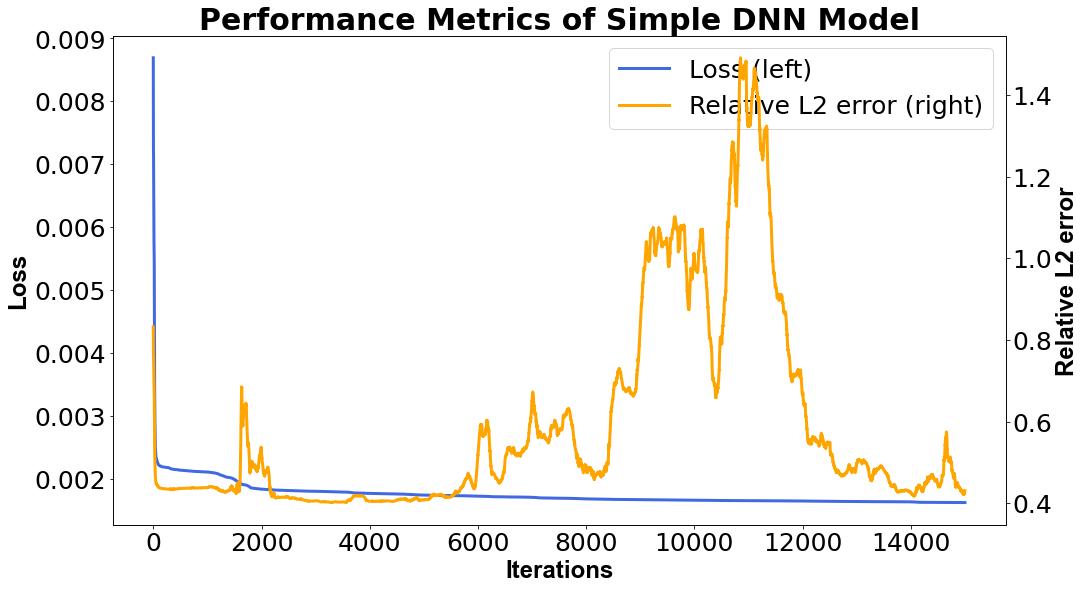

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.016473071724532523
MSE =  0.003781073821587919
RMSE =  0.06149043683035533
L2 relative error = 0.5465185101662158
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

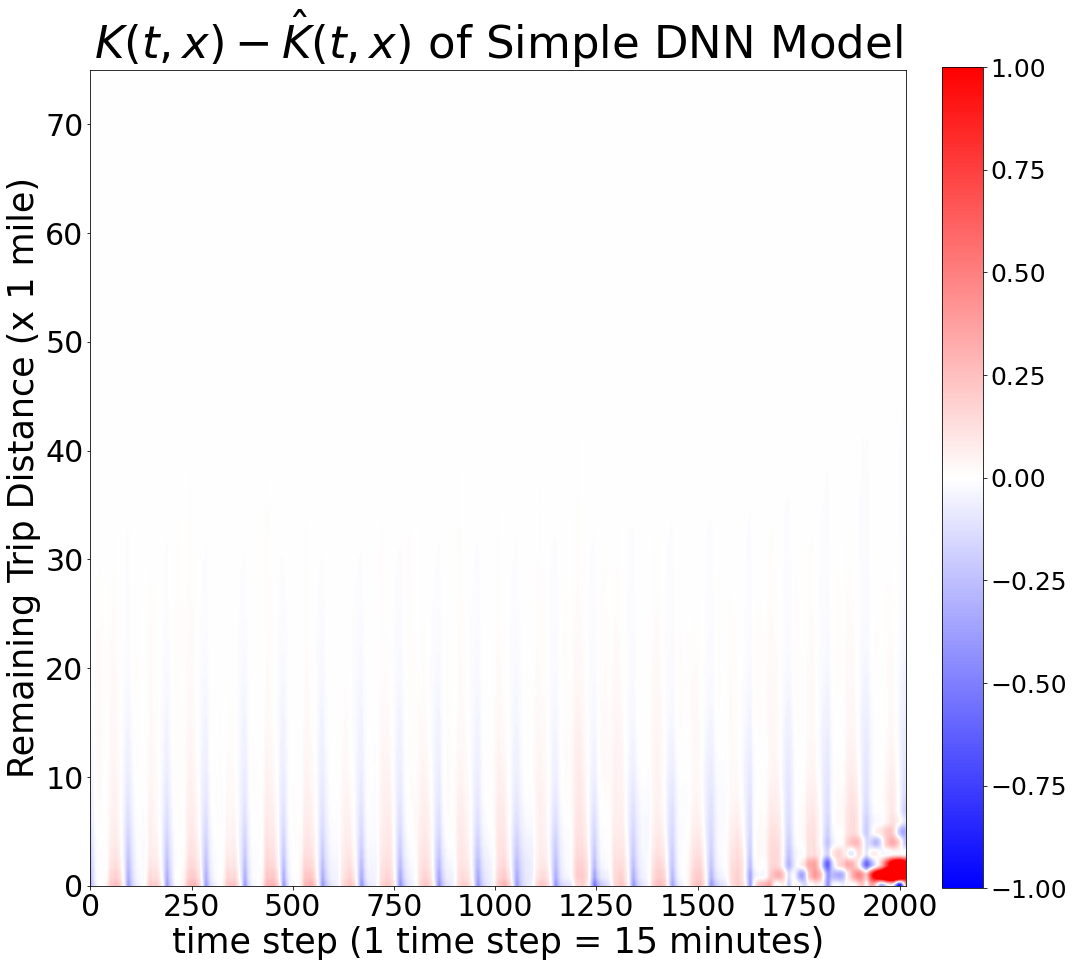

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

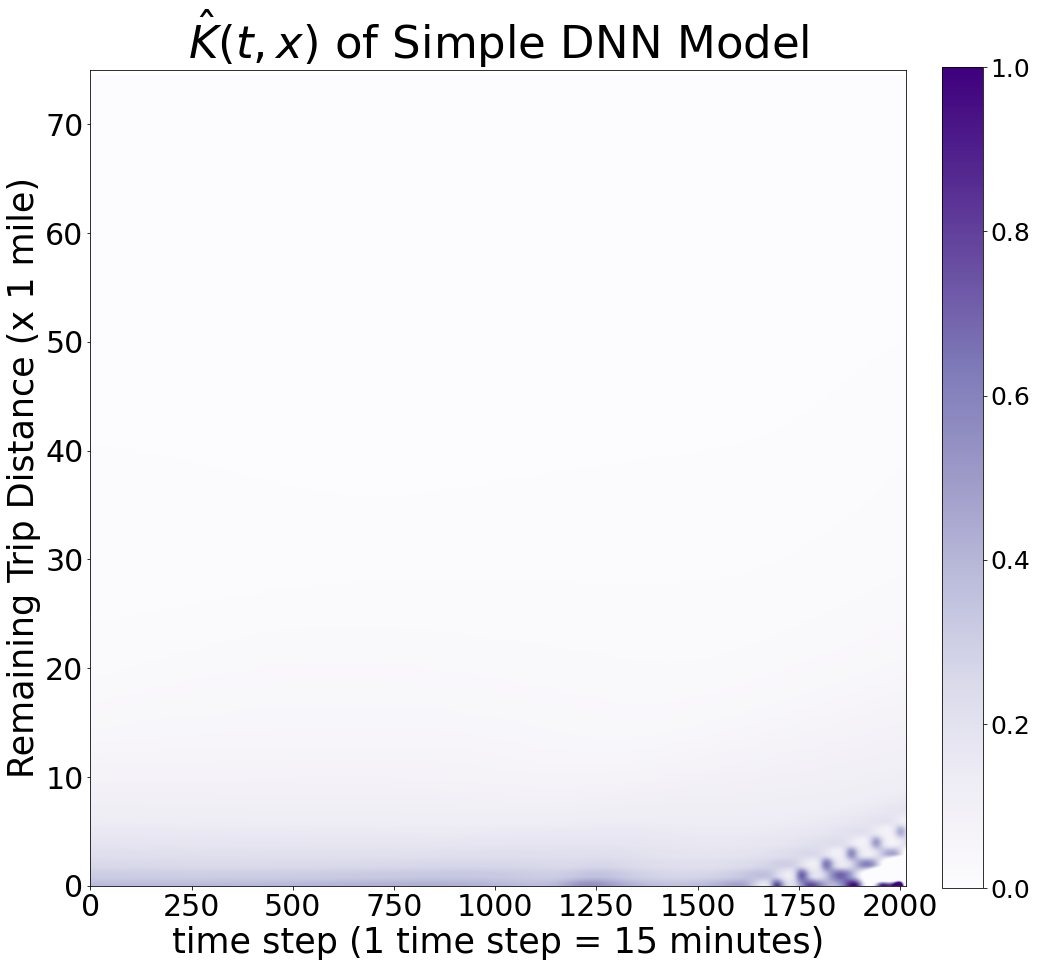

In [26]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

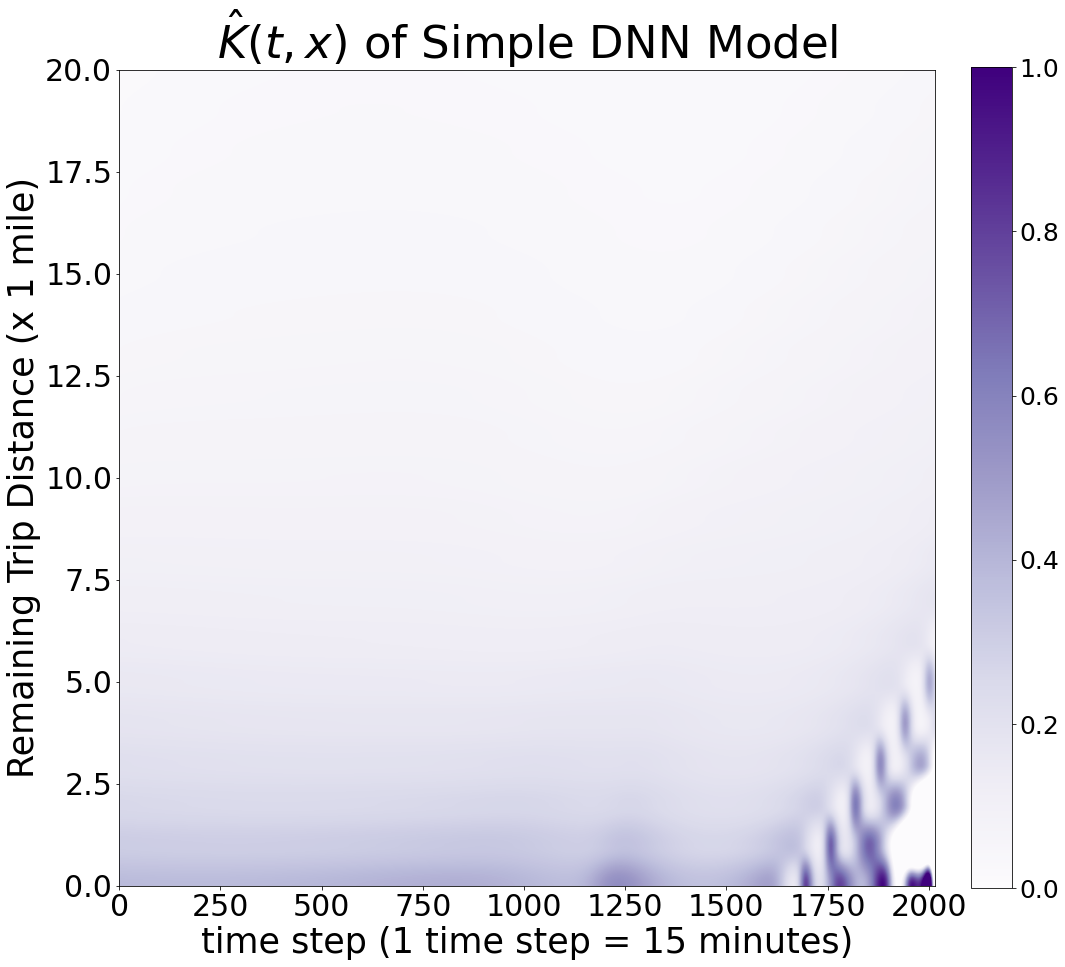

In [27]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

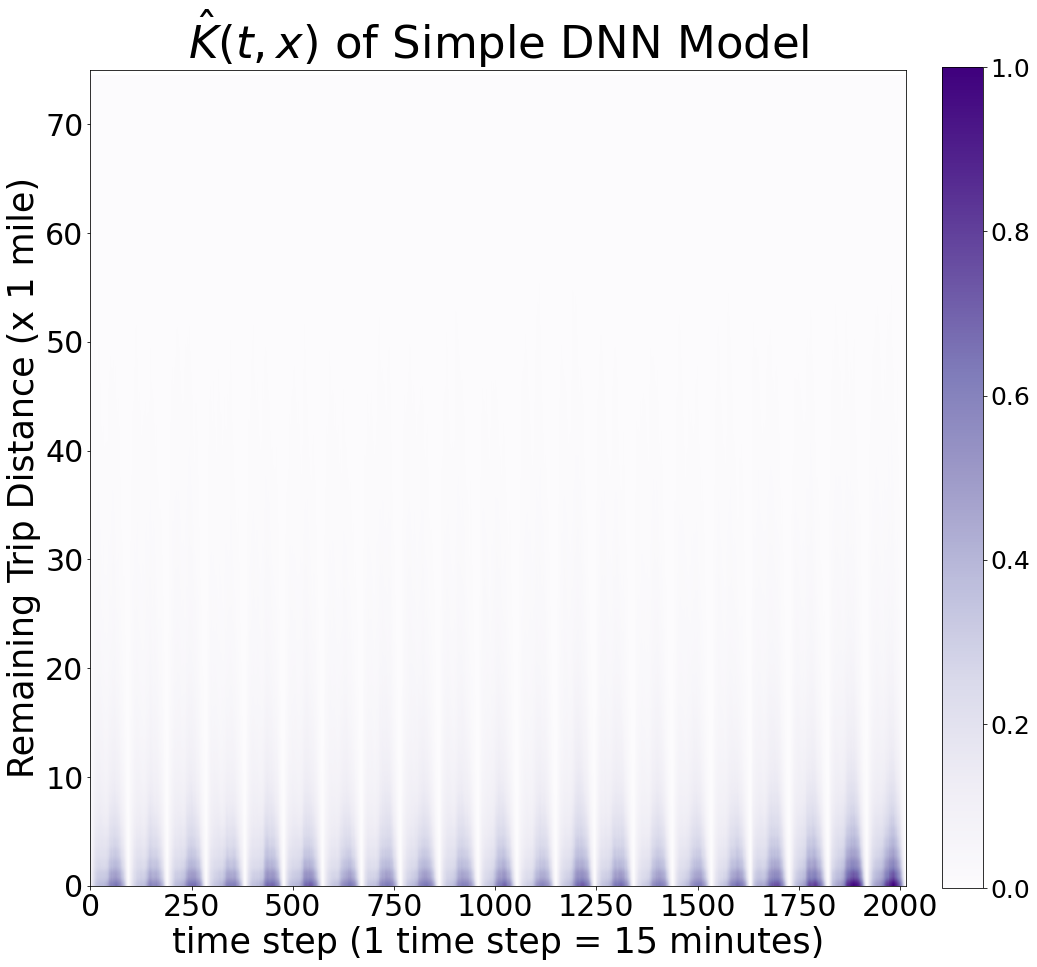

In [28]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

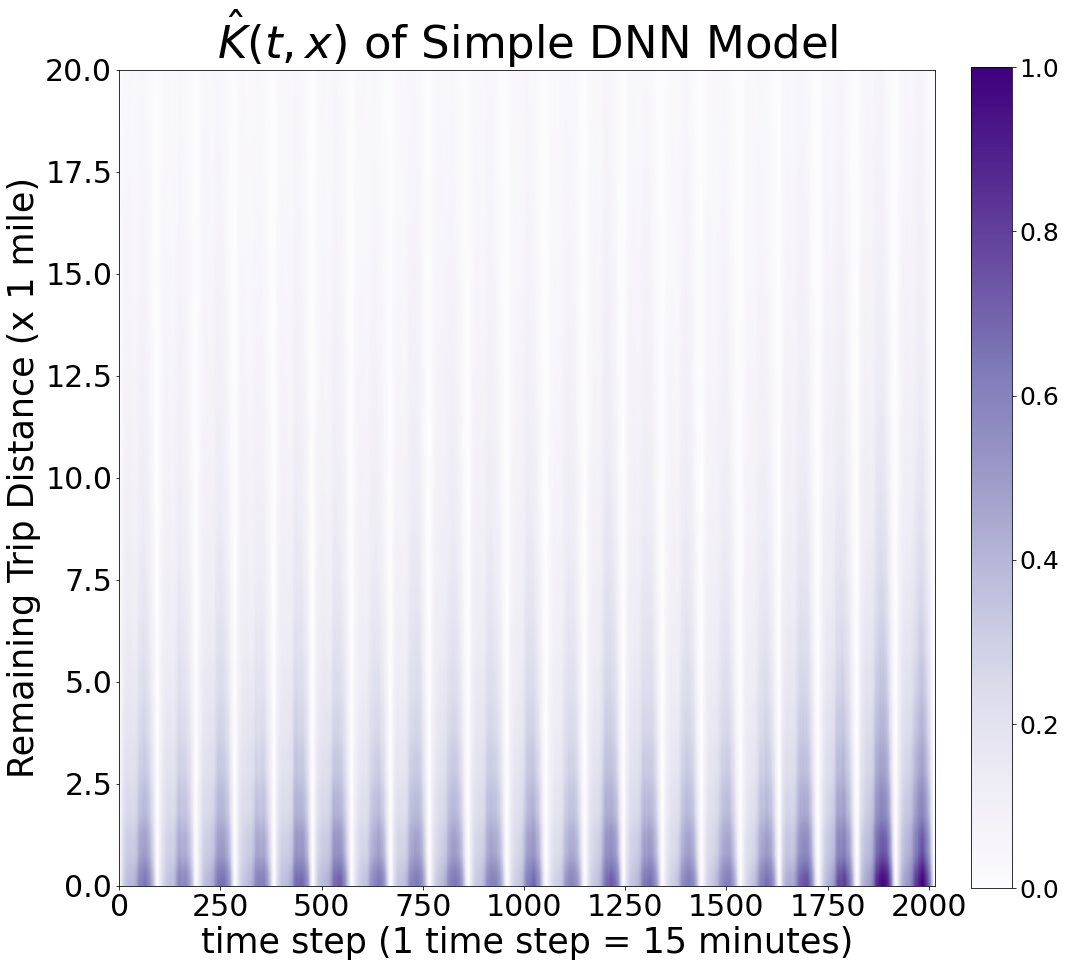

In [29]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

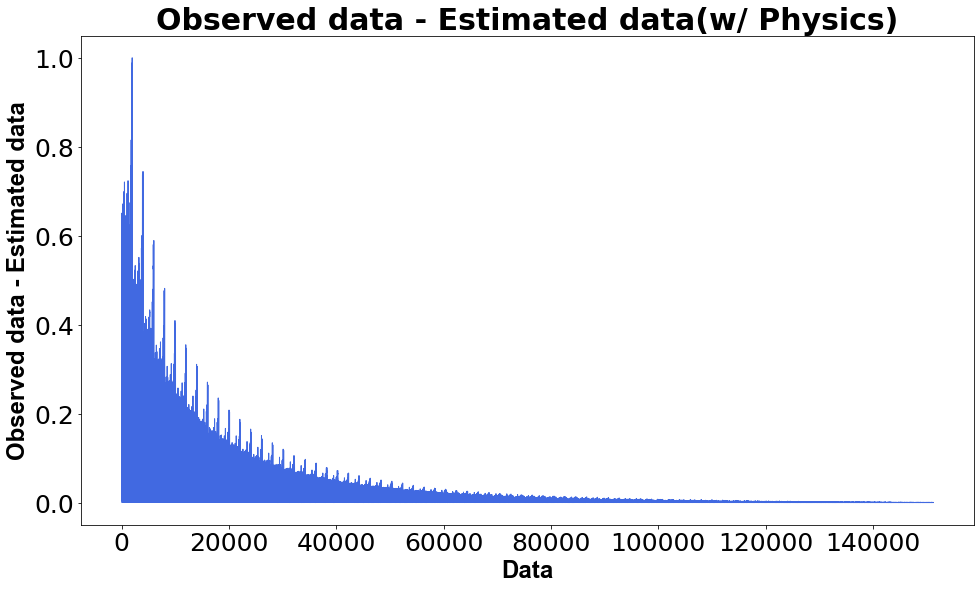

In [30]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)